In [1]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
from datetime import datetime
import random
import argparse
import math
import os
import json
import numpy as np
import copy
import pickle
import matplotlib.pyplot as plt
from torch import nn, optim
from scipy import stats
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from torch.utils.tensorboard import SummaryWriter

from google.colab import drive
import sys
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/enze/workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)
from cyclic_lr_scheduler import CyclicLR
from utils import draw_two_dimension, draw_two_dimension_different_x, draw_multiple_loss

Mounted at /content/drive


In [5]:
norm = torch.nn.MSELoss()

a = torch.Tensor([[1,2,3], [2,2,2]])
print(a.shape)
b = torch.Tensor([[2,3,4], [3,3,3]])
print(b.shape)
print(norm(a, b))

a = torch.Tensor([1,2,3])
print(a.shape)
b = torch.Tensor([2,3,4])
print(b.shape)
print(norm(a, b))

torch.Size([2, 3])
torch.Size([2, 3])
tensor(1.)
torch.Size([3])
torch.Size([3])
tensor(1.)


In [ ]:
# rmse = RMSELoss()
# mse = nn.MSELoss()
# zeros_1D = torch.Tensor([[0.0]] * 3)
# a = torch.Tensor([[1], [2], [3]])
# print(rmse(a, zeros_1D))
# print(mse(a, zeros_1D))


In [ ]:
class ConfigSIRAges:
    def __init__(self):
        self.model_name = "SimpleNetworkSIRAges_Truth"
        self.T = 100.0
        self.T_all = self.T
        self.T_unit = 0.1
        self.N = int(self.T / self.T_unit)
        self.S_start = 50.0  # 99.0
        self.I_start = 40.0 # 1.0
        self.R_start = 10.0 # 0.0
        self.NN = self.S_start + self.I_start + self.R_start
        self.beta = 0.01  # 0.01
        self.gamma = 0.05 # 0.05
        self.ub = self.T
        self.lb = 0.0
        self.mu = 0.03
        self.lam = self.mu * self.NN

        self.M = np.asarray([
          [19.200, 4.800, 5.050, 3.400, 1.700],
          [4.800, 42.400, 5.900, 6.250, 1.733],
          [5.050, 5.900, 14.000, 7.575, 1.700],
          [3.400, 6.250, 7.575, 9.575, 1.544],
          [1.700, 1.733, 1.700, 1.544, 5.456],
        ])
        self.n = len(self.M)

        self.seed = 0
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gt_real = GroundTruthSIRAges(self.T, self.N)
        self.gt_real_data = torch.tensor(self.gt_real.data).to(self.device)
        self.x_real = torch.tensor(np.asarray([[i*self.T_unit] * (self.n * 3) for i in range(self.N)]) / self.T_all * 2.0 - 1.0).float().to(self.device)
        print("[continuous] self.x_real: shape = {}".format(self.x_real.shape))

        self.only_truth_flag = False
        self.truth_rate = 0.001
        self.truth_length = int(self.truth_rate * self.T / self.T_unit)

        self.continuous_flag = False
        self.continue_period = 0.2
        self.round_bit = 3
        self.continue_id = None
        self.mapping_overall_flag = True

        self.sliding_window_flag = False
        self.sw_normal_flag=False
        self.normal_sliding_window_step = 50000
        self.sw_brick_flag=False
        self.epoch_max=None
        


# class RMSELoss(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.eps = 1e-8
        
#     def forward(self, y_pred, y):
#         return torch.sqrt(self.mse(y_pred, y) + self.eps)

def RMSELoss(y_pred, y):
    return torch.sqrt(torch.mean((y_pred - y)**2) + 1e-12)


class SimpleNetworkSIRAges(nn.Module):
    def __init__(self, config, truth=None):
        super(SimpleNetworkSIRAges, self).__init__()
        self.config = config
        print("self.truth_length: {} of {} all ".format(self.config.truth_length, self.config.N))
        self.setup_seed(self.config.seed)
        self.device = self.config.device
        self.x, self.y0, self.t0 = None, None, None
        self.accurate_x = None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = self.config.model_name
        self.gt = GroundTruthSIRAges(self.config.T, self.config.N)
        self.gt_data = torch.Tensor(self.gt.data).to(self.device)
        self.y_record = None
        self.sig = nn.Tanh()

        self.loss_norm = RMSELoss
        self.truth = truth if truth else [[], []]
        self.truth_dic = {round(self.truth[0][i], self.config.round_bit): self.truth[1][i] for i in range(len(self.truth[0]))}

        self.network_unit = 20
        # Design A
        # id = 1
        self.fc_x1_id1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 2
        self.fc_x1_id2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 3
        self.fc_x1_id3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 4
        self.fc_x1_id4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id4 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # id = 5
        self.fc_x1_id5 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x2_id5 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc_x3_id5 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, self.network_unit),
            'sig1': self.sig,
            'lin2': nn.Linear(self.network_unit, self.network_unit),
            'sig2': self.sig,
            'lin3': nn.Linear(self.network_unit, self.network_unit),
            'sig3': self.sig,
            'lin4': nn.Linear(self.network_unit, 1),
            # 'sig4': nn.ReLU()
        }))

        # # Design D
        # # id = 1
        # self.fc_x1_0_1_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 2
        # self.fc_x1_0_1_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 3
        # self.fc_x1_0_1_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 4
        # self.fc_x1_0_1_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # # id = 5
        # self.fc_x1_0_1_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear((self.config.n + 1) * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1 * self.network_unit, self.network_unit),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x2_3_4_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

        # self.fc_x3_3_4_id5 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(self.network_unit, 1),
        # }))

    def forward(self, inputs):
        # print(inputs.shape)
        # print("inputs=", inputs)
        x1_id1, x1_id2, x1_id3, x1_id4, x1_id5, x2_id1, x2_id2, x2_id3, x2_id4, x2_id5, x3_id1, x3_id2, x3_id3, x3_id4, x3_id5 = torch.chunk(inputs, 15, 1)
        
        # Design A
        x1_new_id1 = self.fc_x1_id1(x1_id1)
        x2_new_id1 = self.fc_x2_id1(x2_id1)
        x3_new_id1 = self.fc_x3_id1(x3_id1)

        x1_new_id2 = self.fc_x1_id2(x1_id2)
        x2_new_id2 = self.fc_x2_id2(x2_id2)
        x3_new_id2 = self.fc_x3_id2(x3_id2)

        x1_new_id3 = self.fc_x1_id3(x1_id3)
        x2_new_id3 = self.fc_x2_id3(x2_id3)
        x3_new_id3 = self.fc_x3_id3(x3_id3)

        x1_new_id4 = self.fc_x1_id4(x1_id4)
        x2_new_id4 = self.fc_x2_id4(x2_id4)
        x3_new_id4 = self.fc_x3_id4(x3_id4)

        x1_new_id5 = self.fc_x1_id5(x1_id5)
        x2_new_id5 = self.fc_x2_id5(x2_id5)
        x3_new_id5 = self.fc_x3_id5(x3_id5)


        # # Design D
        # # 1 output train
        # x1_1_output_id1 = self.fc_x1_0_1_id1(x1_id1)
        # x2_1_output_id1 = self.fc_x2_0_1_id1(x2_id1)
        # x3_1_output_id1 = self.fc_x3_0_1_id1(x3_id1)

        # x1_1_output_id2 = self.fc_x1_0_1_id2(x1_id2)
        # x2_1_output_id2 = self.fc_x2_0_1_id2(x2_id2)
        # x3_1_output_id2 = self.fc_x3_0_1_id2(x3_id2)

        # x1_1_output_id3 = self.fc_x1_0_1_id3(x1_id3)
        # x2_1_output_id3 = self.fc_x2_0_1_id3(x2_id3)
        # x3_1_output_id3 = self.fc_x3_0_1_id3(x3_id3)

        # x1_1_output_id4 = self.fc_x1_0_1_id4(x1_id4)
        # x2_1_output_id4 = self.fc_x2_0_1_id4(x2_id4)
        # x3_1_output_id4 = self.fc_x3_0_1_id4(x3_id4)

        # x1_1_output_id5 = self.fc_x1_0_1_id5(x1_id5)
        # x2_1_output_id5 = self.fc_x2_0_1_id5(x2_id5)
        # x3_1_output_id5 = self.fc_x3_0_1_id5(x3_id5)

        # # 2 input cat
        # x1_2_input_id1 = torch.cat((x1_1_output_id1, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id1 = torch.cat((x1_1_output_id1, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id1 = x2_1_output_id1

        # x1_2_input_id2 = torch.cat((x1_1_output_id2, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id2 = torch.cat((x1_1_output_id2, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id2 = x2_1_output_id2

        # x1_2_input_id3 = torch.cat((x1_1_output_id3, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id3 = torch.cat((x1_1_output_id3, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id3 = x2_1_output_id3

        # x1_2_input_id4 = torch.cat((x1_1_output_id4, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id4 = torch.cat((x1_1_output_id4, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id4 = x2_1_output_id4

        # x1_2_input_id5 = torch.cat((x1_1_output_id5, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x2_2_input_id5 = torch.cat((x1_1_output_id5, x2_1_output_id1, x2_1_output_id2, x2_1_output_id3, x2_1_output_id4, x2_1_output_id5), 1)
        # x3_2_input_id5 = x2_1_output_id5

        # # 2 output train
        # x1_2_output_id1 = self.fc_x1_1_2_id1(x1_2_input_id1)
        # x2_2_output_id1 = self.fc_x2_1_2_id1(x2_2_input_id1)
        # x3_2_output_id1 = self.fc_x3_1_2_id1(x3_2_input_id1)

        # x1_2_output_id2 = self.fc_x1_1_2_id2(x1_2_input_id2)
        # x2_2_output_id2 = self.fc_x2_1_2_id2(x2_2_input_id2)
        # x3_2_output_id2 = self.fc_x3_1_2_id2(x3_2_input_id2)

        # x1_2_output_id3 = self.fc_x1_1_2_id3(x1_2_input_id3)
        # x2_2_output_id3 = self.fc_x2_1_2_id3(x2_2_input_id3)
        # x3_2_output_id3 = self.fc_x3_1_2_id3(x3_2_input_id3)

        # x1_2_output_id4 = self.fc_x1_1_2_id4(x1_2_input_id4)
        # x2_2_output_id4 = self.fc_x2_1_2_id4(x2_2_input_id4)
        # x3_2_output_id4 = self.fc_x3_1_2_id4(x3_2_input_id4)

        # x1_2_output_id5 = self.fc_x1_1_2_id5(x1_2_input_id5)
        # x2_2_output_id5 = self.fc_x2_1_2_id5(x2_2_input_id5)
        # x3_2_output_id5 = self.fc_x3_1_2_id5(x3_2_input_id5)

        # # 3 input cat
        # x1_3_input_id1 = torch.cat((x1_2_output_id1, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id1 = torch.cat((x1_2_output_id1, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id1 = x2_2_output_id1

        # x1_3_input_id2 = torch.cat((x1_2_output_id2, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id2 = torch.cat((x1_2_output_id2, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id2 = x2_2_output_id2

        # x1_3_input_id3 = torch.cat((x1_2_output_id3, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id3 = torch.cat((x1_2_output_id3, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id3 = x2_2_output_id3

        # x1_3_input_id4 = torch.cat((x1_2_output_id4, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id4 = torch.cat((x1_2_output_id4, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id4 = x2_2_output_id4

        # x1_3_input_id5 = torch.cat((x1_2_output_id5, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x2_3_input_id5 = torch.cat((x1_2_output_id5, x2_2_output_id1, x2_2_output_id2, x2_2_output_id3, x2_2_output_id4, x2_2_output_id5), 1)
        # x3_3_input_id5 = x2_2_output_id5

        # # 3 output train
        # x1_3_output_id1 = self.fc_x1_2_3_id1(x1_3_input_id1)
        # x2_3_output_id1 = self.fc_x2_2_3_id1(x2_3_input_id1)
        # x3_3_output_id1 = self.fc_x3_2_3_id1(x3_3_input_id1)

        # x1_3_output_id2 = self.fc_x1_2_3_id2(x1_3_input_id2)
        # x2_3_output_id2 = self.fc_x2_2_3_id2(x2_3_input_id2)
        # x3_3_output_id2 = self.fc_x3_2_3_id2(x3_3_input_id2)

        # x1_3_output_id3 = self.fc_x1_2_3_id3(x1_3_input_id3)
        # x2_3_output_id3 = self.fc_x2_2_3_id3(x2_3_input_id3)
        # x3_3_output_id3 = self.fc_x3_2_3_id3(x3_3_input_id3)

        # x1_3_output_id4 = self.fc_x1_2_3_id4(x1_3_input_id4)
        # x2_3_output_id4 = self.fc_x2_2_3_id4(x2_3_input_id4)
        # x3_3_output_id4 = self.fc_x3_2_3_id4(x3_3_input_id4)

        # x1_3_output_id5 = self.fc_x1_2_3_id5(x1_3_input_id5)
        # x2_3_output_id5 = self.fc_x2_2_3_id5(x2_3_input_id5)
        # x3_3_output_id5 = self.fc_x3_2_3_id5(x3_3_input_id5)

        # # final output
        # x1_new_id1 = self.fc_x1_3_4_id1(x1_3_output_id1)
        # x2_new_id1 = self.fc_x2_3_4_id1(x2_3_output_id1)
        # x3_new_id1 = self.fc_x3_3_4_id1(x3_3_output_id1)

        # x1_new_id2 = self.fc_x1_3_4_id2(x1_3_output_id2)
        # x2_new_id2 = self.fc_x2_3_4_id2(x2_3_output_id2)
        # x3_new_id2 = self.fc_x3_3_4_id2(x3_3_output_id2)

        # x1_new_id3 = self.fc_x1_3_4_id3(x1_3_output_id3)
        # x2_new_id3 = self.fc_x2_3_4_id3(x2_3_output_id3)
        # x3_new_id3 = self.fc_x3_3_4_id3(x3_3_output_id3)

        # x1_new_id4 = self.fc_x1_3_4_id4(x1_3_output_id4)
        # x2_new_id4 = self.fc_x2_3_4_id4(x2_3_output_id4)
        # x3_new_id4 = self.fc_x3_3_4_id4(x3_3_output_id4)

        # x1_new_id5 = self.fc_x1_3_4_id5(x1_3_output_id5)
        # x2_new_id5 = self.fc_x2_3_4_id5(x2_3_output_id5)
        # x3_new_id5 = self.fc_x3_3_4_id5(x3_3_output_id5)

        outputs = torch.cat((x1_new_id1, x1_new_id2, x1_new_id3, x1_new_id4, x1_new_id5, x2_new_id1, x2_new_id2, x2_new_id3, x2_new_id4, x2_new_id5, x3_new_id1, x3_new_id2, x3_new_id3, x3_new_id4, x3_new_id5), 1)
        return outputs

    def generate_x(self):
        x = [[i*self.config.T_unit] * (self.config.n * 3) for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)
        self.accurate_x = [i*self.config.T_unit for i in range(self.config.N)]
        print("[continuous] self.x: shape = {}".format(self.x.shape))

    def initial_start(self):
        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0, -1.0] * self.config.n).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray(
            [self.config.S_start] * self.config.n + [self.config.I_start] * self.config.n + [self.config.R_start] * self.config.n
            ).reshape([1, -1])).float().to(self.device)
        # self.yend = torch.Tensor(np.asarray([0, 0, 100]).reshape([1, -1])).float().to(self.device)
        # self.tend = torch.Tensor(np.asarray([1.0, 1.0, 1.0]).reshape([1, -1])).float().to(self.device)
    
    def loss_only_ground_truth(self):
        self.eval()
        y = self.forward(self.x)
        self.y_record = y
        # self.loss_norm = torch.nn.MSELoss().to(self.device)
        # print(y.shape, self.gt_data.shape)
        loss = self.loss_norm(y, self.gt_data)
        self.train()
        return loss, [loss]
    
    def real_loss(self):
        self.eval()
        y = self.forward(self.config.x_real)
        real_loss = self.loss_norm(y[:self.config.N, :], self.config.gt_real_data[:self.config.N, :])
        return real_loss


    def loss(self, epoch=None):
        self.eval()
        # cp = CheckPoint()
        y = self.forward(self.x)
        self.y_record = y
        # s = y[:, 0:1]
        # i = y[:, 1:2]
        # r = y[:, 2:3]
        # cp.time("c1")
        s = y[:, 0: self.config.n]
        i = y[:, self.config.n: self.config.n * 2]
        r = y[:, self.config.n * 2: self.config.n * 3]

        s_t_collection, i_t_collection, r_t_collection = [], [], []
        for ii in range(self.config.n):
          s_t_collection.append(torch.gradient(s[:,ii:ii+1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1]))
          i_t_collection.append(torch.gradient(i[:,ii:ii+1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1]))
          r_t_collection.append(torch.gradient(r[:,ii:ii+1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N,1]))
        s_t = torch.cat(s_t_collection, 1)
        i_t = torch.cat(i_t_collection, 1)
        r_t = torch.cat(r_t_collection, 1)

        # cp.time("c2")
        # s_ids, i_ids, r_ids = [], [], []
        # for i in range(self.config.n):
        #   s_ids.append(y[:, i:i+1])
        #   i_ids.append(y[:, self.config.n+i: self.config.n+i+1])
        #   r_ids.append(y[:, 2*self.config.n+i: 2*self.config.n+i+1])
        
        # s_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        # i_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
        # r_t = torch.gradient(y[:, 2:3].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 2:3].reshape([self.config.N]),))[0]
        # s_t_ids, i_t_ids, r_t_ids = [], [], []
        # for i in range(self.config.n):
        #   s_t_ids.append(torch.gradient(s_ids[i].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N, 1]))
        #   i_t_ids.append(torch.gradient(i_ids[i].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N, 1]))
        #   r_t_ids.append(torch.gradient(r_ids[i].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0].reshape([self.config.N, 1]))
        
        # s_t = s_t.reshape([self.config.N, 1])
        # i_t = i_t.reshape([self.config.N, 1])
        # r_t = r_t.reshape([self.config.N, 1])
        
        # f_s = s_t - (- self.config.beta * s * i / self.config.NN + self.config.lam - self.config.mu * s)
        # f_i = i_t - (self.config.beta * s * i / self.config.NN - self.config.gamma * i - self.config.mu * i)
        # f_r = r_t - (self.config.gamma * i - self.config.mu * r)

        tmp_s_t_target_collection, tmp_i_t_target_collection, tmp_r_t_target_collection = [], [], []
        for ii in range(self.config.n):
          tmp_s_t_target = torch.zeros([self.config.N, 1]).to(self.device)
          tmp_i_t_target = torch.zeros([self.config.N, 1]).to(self.device)
          tmp_r_t_target = torch.zeros([self.config.N, 1]).to(self.device)
          for jj in range(self.config.n):
            # print(s[:, ii:ii+1].shape)
            # print(self.config.M[i][jj])
            tmp_s_t_target += (-self.config.beta * s[:, ii:ii+1] * self.config.M[ii][jj] * i[:, jj:jj+1]) / self.config.NN
            tmp_i_t_target += (self.config.beta * s[:, ii:ii+1] * self.config.M[ii][jj] * i[:, jj:jj+1]) / self.config.NN
          tmp_i_t_target -= self.config.gamma * i[:, ii:ii+1]
          tmp_r_t_target += self.config.gamma * i[:, ii:ii+1]
          tmp_s_t_target += (- self.config.mu * s[:, ii:ii+1] + self.config.lam)
          tmp_i_t_target += (- self.config.mu * i[:, ii:ii+1])
          tmp_r_t_target += (- self.config.mu * r[:, ii:ii+1])
          tmp_s_t_target_collection.append(tmp_s_t_target)
          tmp_i_t_target_collection.append(tmp_i_t_target)
          tmp_r_t_target_collection.append(tmp_r_t_target)
        s_t_target = torch.cat(tmp_s_t_target_collection, 1)
        i_t_target = torch.cat(tmp_i_t_target_collection, 1)
        r_t_target = torch.cat(tmp_r_t_target_collection, 1)

        f_s = s_t - s_t_target
        f_i = i_t - i_t_target
        f_r = r_t - r_t_target
        # cp.time("c3")
        
        f_y = torch.cat((f_s, f_i, f_r), 1)
        y0_pred = self.forward(self.t0)
        
        # i_1 = i[:, 0:1]
        # i_2 = i[:, 1:2]
        # i_3 = i[:, 2:3]
        # i_4 = i[:, 3:4]
        # i_5 = i[:, 4:5]

        # r_1 = r[:, 0:1]
        # r_2 = r[:, 1:2]
        # r_3 = r[:, 2:3]
        # r_4 = r[:, 3:4]
        # r_5 = r[:, 4:5]

        # loss_1 = torch.mean(torch.square(self.y0 - y0_pred))
        # self.loss_norm = torch.nn.MSELoss().to(self.device)
        # self.loss_norm = RMSELoss # nn.MSELoss().to(self.device) #RMSELoss().to(self.device)

        # zeros_1D = torch.Tensor([[0.0]] * self.config.N).to(self.device)
        # zeros_2D = torch.Tensor([[0.0, 0.0]] * self.config.N).to(self.device)
        # zeros_3D = torch.Tensor([[0.0, 0.0, 0.0]] * self.config.N).to(self.device)
        zeros_15D = torch.Tensor([[0.0] * 15] * self.config.N).to(self.device)
        # print("y[:self.config.truth_length, :]", y[:self.config.truth_length, :].shape, y[:self.config.truth_length, :])
        # print("self.gt_data[:self.config.truth_length, :]", self.gt_data[:self.config.truth_length, :].shape, self.gt_data[:self.config.truth_length, :])
        # print("zeros_15D", zeros_15D.shape, zeros_15D)
        # print("f_y", f_y.shape, f_y)
        # print("torch.abs(y) - y", (torch.abs(y) - y).shape, torch.abs(y) - y)
        loss_1 = self.loss_norm(y[:self.config.truth_length, :], self.gt_data[:self.config.truth_length, :])
        # cp.time("c4")
        if self.config.sliding_window_flag:
            if self.config.sw_normal_flag:
                self.loss_2_weight_numpy = generate_normal_distribution_weight(self.config.N, self.config.n * 3, (epoch % int(self.config.normal_sliding_window_step)) / self.config.normal_sliding_window_step)
                loss_2 = self.loss_norm(f_y * torch.Tensor(self.loss_2_weight_numpy).to(self.device), zeros_15D)
            else:
                self.loss_2_weight_numpy = generate_brick_distribution_weight(self.config.N, self.config.n * 3, epoch / self.config.epoch_max)
                loss_2 = self.loss_norm(f_y * torch.Tensor(self.loss_2_weight_numpy).to(self.device), zeros_15D)

        else:
            loss_2 = self.loss_norm(f_y, zeros_15D) #torch.mean(torch.square(f_y))  # + torch.var(torch.square(f_y))

        loss_3 = self.loss_norm(torch.abs(y), y) # torch.mean(torch.square((torch.abs(s) - s))) + torch.mean(torch.square((torch.abs(i) - i))) + torch.mean(torch.square((torch.abs(r) - r))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(0.00001 / ((s * s + i * i) * (i * i + r * r) * (s * s + r * r) + 1e-8)))
        loss_4 = self.match_truth(self.accurate_x, y.cpu().detach().numpy())
        # cp.time("c5")
        # 04/27 TODO: re-design the loss functions. I want to do it but Chen asked me to implement new models. Now it's your turn.

        loss = loss_1 + loss_2 + loss_3 + loss_4
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        # cp.time("c6")
        return loss, [loss_1, loss_2, loss_3, loss_4]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)
    
    def match_truth(self, x, y):
        # print(type(x), type(y))
        if len(self.truth[0]) == 0:
            return torch.Tensor([0.0]).to(self.device)
        diff = [np.abs(y_tmp - self.truth_dic.get(round(x_tmp, self.config.round_bit))) for x_tmp, y_tmp in zip(x, y) if round(x_tmp, self.config.round_bit) in self.truth_dic]
        diff = torch.Tensor(diff).to(self.device)
        zeros_2D = torch.Tensor([[0.0] * self.config.n * 3] * len(diff)).to(self.device)
        loss_truth_match = self.loss_norm(diff, zeros_2D)
        if len(diff) != len(self.truth[0]):
            print("Error: match_truth: {} / {} items to match, loss_truth_match = {}".format(len(diff), len(self.truth[0]), loss_truth_match.item()))
        return loss_truth_match

    def encode_t(self, num):
        if not self.config.mapping_overall_flag:
            return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0
        return num / self.config.T_all * 2.0 - 1.0

    def decode_t(self, num):
        if not self.config.mapping_overall_flag:
            return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)
        return (num + 1.0) / 2.0 * self.config.T_all

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [ ]:
class GroundTruthSIRAges:
  def __init__(self, t_max, length):
    S_start = 50.0  # 99.0
    I_start = 40.0 # 1.0
    R_start = 10#1.0 # 0.0
    NN = S_start + I_start + R_start
    beta = 0.01
    gamma = 0.05
    mu = 0.03
    lam = mu * NN
    
    # print(t)
    M = np.asarray([
          [19.200, 4.800, 5.050, 3.400, 1.700],
          [4.800, 42.400, 5.900, 6.250, 1.733],
          [5.050, 5.900, 14.000, 7.575, 1.700],
          [3.400, 6.250, 7.575, 9.575, 1.544],
          [1.700, 1.733, 1.700, 1.544, 5.456],
        ])
    self.n = len(M)
    y0 = np.asarray([S_start] * self.n + [I_start] * self.n + [R_start] * self.n)
    self.t = np.linspace(0, t_max, length)
    self.data = odeint(self.pend, y0, self.t, args=(M, beta, gamma, NN, self.n, mu, lam))
  
  @staticmethod
  def pend(y, t, M, beta, gamma, NN, n, mu, lam):
    map = y
    #dydt = np.asarray([(a * map[0]) - c * map[0] * map[1], - b * map[1] + d * c * map[0] * map[1]])
    S_arr = y[0: n]
    I_arr = y[n: 2 * n]
    R_arr = y[2 * n: 3 * n]
    ds = []
    di = []
    dr = []
    for i in range(n):
      ds.append(- beta * S_arr[i] / NN * sum([M[i][j] * I_arr[j] for j in range(n)]) - mu * S_arr[i] + lam)
      di.append(beta * S_arr[i] / NN * sum([M[i][j] * I_arr[j] for j in range(n)]) - gamma * I_arr[i] - mu * I_arr[i])
      dr.append(gamma * I_arr[i] - mu * R_arr[i])
    dydt = np.asarray(ds + di + dr)
    return dydt
  
  def print(self):
    y_lists = [self.data[:, i] for i in range(3 * self.n)]
    x_list = self.t
    color_list = ["red"] * self.n + ["blue"] * self.n + ["green"] * self.n
    labels = ["0-9", "10-19", "20-39", "40-59", "60+"]
    legend_list = ["S{}({})".format(i + 1, labels[i]) for i in range(self.n)] + ["I{}({})".format(i + 1, labels[i]) for i in range(self.n)] + ["R{}({})".format(i + 1, labels[i]) for i in range(self.n)]
    line_style_list = ["dashed", "dotted", "dashdot", (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10))] * 3

    draw_two_dimension(
        y_lists=y_lists,
        x_list=x_list,
        color_list=color_list,
        legend_list=legend_list,
        line_style_list=line_style_list,
        fig_title="Ground Truth: SIR - Ages",
        fig_size=(8, 6),
        show_flag=True,
        save_flag=False,
        save_path=None
    )
class CheckPoint:
  def __init__(self):
    self.id = 0
    self.t = time.time()

  def full_time(self):
    # return time.strftime("%Y-%m-%d-%H-%M-%S.%fZ", time.localtime(time.time()))
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f")
  
  def time(self, label=None):
    self.id += 1
    t_new = time.time()
    print("[{0}] Check Point {1:02d}: {2:.12f}s{3}".format(self.full_time(), self.id, t_new - self.t, " ({})".format(label) if label else ""))
    self.t = t_new


def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def generate_normal_distribution_weight(length, width, mu_location):
    mu = mu_location * length
    sigma = length // 10
    x = np.linspace(0, length, length)
    y = 1e2 * length * stats.norm.pdf(x, mu, sigma)
    y = y / y.sum() * length
    # print(y)
    # plt.plot(x, y)
    # print(x[:5], x[-5:])
    # print(y.shape)
    # print(y)
    # plt.show()
    res = np.column_stack([y for i in range(width)])
    # print(res.shape)
    return res

def generate_brick_distribution_weight(length, width, epoch_ratio, epoch_freeze=0.15, epoch_moving=0.05, epoch_final=0.40):
    # epoch_ratio = epoch / epoch_max
    if epoch_ratio <= epoch_freeze:
      weight_range = [0, 0.25 * length]
    elif epoch_freeze < epoch_ratio <= epoch_freeze + epoch_moving:
      weight_range = [0, (0.25 + (epoch_ratio - (1 * epoch_freeze)) / epoch_moving * 0.25) * length]
    elif epoch_freeze + epoch_moving < epoch_ratio <= 2 * epoch_freeze + epoch_moving:
      weight_range = [0, 0.5 * length]
    elif 2 * epoch_freeze + epoch_moving < epoch_ratio <= 2 * epoch_freeze + 2 * epoch_moving:
      weight_range = [0, (0.5 + (epoch_ratio - (2 * epoch_freeze + epoch_moving)) / epoch_moving * 0.25) * length]
    elif 2 * epoch_freeze + 2 * epoch_moving < epoch_ratio <= 3 * epoch_freeze + 2 * epoch_moving:
      weight_range = [0, 0.75 * length]
    elif 3 * epoch_freeze + 2 * epoch_moving < epoch_ratio <= 3 * epoch_freeze + 3 * epoch_moving:
      weight_range = [0, (0.75 + (epoch_ratio - (3 * epoch_freeze + 2 * epoch_moving)) / epoch_moving * 0.25) * length]
    elif 3 * epoch_freeze + 3 * epoch_moving < epoch_ratio <= 1.0:
      weight_range = [0, 1.0 * length]

    weight_high = length * 1 / (weight_range[1] - weight_range[0])
    y = [weight_high if i < weight_range[1] else 0 for i in range(length)]
    y = np.asarray(y)
    y = y / y.sum() * length
    res = np.column_stack([y for i in range(width)])
    return res


def train_sir_ages(model, args, config, now_string, resume_epoch=None, resume_loss_record=None, resume_real_loss_record=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
    loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"
    real_loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_real_loss_{args.epoch}.npy"
    y_record_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_y_record.npy"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    print("loss_save_path = {}".format(loss_save_path))
    print("real_loss_save_path = {}".format(real_loss_save_path))
    print("y_record_save_path = {}".format(y_record_save_path))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    # scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=1000)
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    best_loss = np.inf
    loss_record = []
    real_loss_record = []
    start_index = 1
    if resume_epoch:
        for i in range(resume_epoch):
            scheduler.step()
        loss_record = resume_loss_record
        real_loss_record = resume_real_loss_record
        start_index = resume_epoch + 1
        print("[Resume] loss_record length:", len(loss_record))
        print("[Resume] real_loss_record length:", len(real_loss_record))
        print("[Resume] start_index:", start_index)
    # y_record = []
    for epoch in range(start_index, args.epoch + 1):
        # cp = CheckPoint()
        optimizer.zero_grad()
        # cp.time("a")
        inputs = model.x
        outputs = model(inputs)
        # cp.time("b")
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        if config.only_truth_flag:
          loss, loss_list = model.loss_only_ground_truth()
        else:
          loss, loss_list = model.loss(epoch)
        # cp.time("c")
        real_loss = model.real_loss()
        # cp.time("d")
        loss.backward()
        # cp.time("e")
        optimizer.step()
        # cp.time("f")
        scheduler.step()
        # cp.time("g")
        loss_record.append(float(loss.item()))
        real_loss_record.append(float(real_loss.item()))
        # y_record.append(model.y_record.cpu().detach().numpy())
        # cp.time("h")
        if epoch % epoch_step == 0:
            now_time = time.time()
            loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
            # print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3: {5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0))
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} {3} Lr:{4:.6f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, args.epoch, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / (epoch - start_index + 1) * (args.epoch - epoch)))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0 or epoch == args.epoch:
            test_sir_ages(model, args, config, now_string, True, model.gt)
            print("[Loss]")
            draw_loss(np.asarray(loss_record))
            print("[Real Loss]")
            draw_loss(np.asarray(real_loss_record))
            np.save(loss_save_path, np.asarray(loss_record))
            np.save(real_loss_save_path, np.asarray(real_loss_record))
            # np.save(y_record_save_path, np.asarray(y_record))
    loss_record = np.asarray(loss_record)
    real_loss_record = np.asarray(real_loss_record)
    res_dic = {
        "start_time": start_time_0,
        "epoch": args.epoch,
        "model_save_path_last": model_save_path_last,
        "model_save_path_best": model_save_path_best,
        "loss_save_path": loss_save_path,
        "real_loss_save_path": real_loss_save_path,
        "best_loss": best_loss,
        "loss_record": loss_record,
        "real_loss_record": real_loss_record
    }
    return model, res_dic

def test_sir_ages(model, args, config, now_string, show_flag=True, gt=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    # model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_last.pt"
    # model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    s, i, r = y[:, 0:5], y[:, 5:10], y[:, 10:15]
    s = s.cpu().detach().numpy()
    i = i.cpu().detach().numpy()
    r = r.cpu().detach().numpy()
    x = model.decode_t(t).cpu().detach().numpy()
    s_pred = [s[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    i_pred = [i[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    r_pred = [r[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n)]
    x = x[:, 0:1].reshape([model.config.N])
    for id in range(model.config.n):
      print(f"s{id+1}=", list(s_pred[id][:10]), "...", list(s_pred[id][-10:]))
    for id in range(model.config.n):
      print(f"i{id+1}=", list(i_pred[id][:10]), "...", list(i_pred[id][-10:]))
    for id in range(model.config.n):
      print(f"r{id+1}=", list(r_pred[id][:10]), "...", list(r_pred[id][-10:]))

    figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    labels = ["0-9", "10-19", "20-39", "40-59", "60+"]
    color_list = ["grey"] * (3 * model.config.n) + ["red"] * model.config.n + ["blue"] * model.config.n + ["green"] * model.config.n
    legend_list = ["S{}({})_truth".format(i + 1, labels[i]) for i in range(model.config.n)] + ["I{}({})_truth".format(i + 1, labels[i]) for i in range(model.config.n)] + ["R{}({})_truth".format(i + 1, labels[i]) for i in range(model.config.n)] + \
                  ["S{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["I{}({})".format(i + 1, labels[i]) for i in range(model.config.n)] + ["R{}({})".format(i + 1, labels[i]) for i in range(model.config.n)]
    line_style_list = ["dashed"] * (3 * model.config.n) + ["dashed", "dotted", "dashdot", (0, (3, 1, 1, 1, 1, 1)), (0, (3, 10, 1, 10))] * 3
    y_truth = [gt.data[:, id:id+1].reshape([model.config.N]) for id in range(model.config.n * 3)]
    if not model.config.sliding_window_flag:
      draw_two_dimension(
          y_lists= y_truth + s_pred + i_pred + r_pred,
          x_list=x,
          color_list=color_list,
          legend_list=legend_list,
          line_style_list=line_style_list,
          fig_title="Predict: SIR - Ages",
          fig_size=(24, 18),
          show_flag=True,
          save_flag=True,
          save_path=figure_save_path
      )
    else:
      sw_weight = [item[0] for item in model.loss_2_weight_numpy]
      draw_two_dimension(
          y_lists= [sw_weight] + y_truth + s_pred + i_pred + r_pred,
          x_list=x,
          color_list=["black"] + color_list,
          legend_list=["sliding window weights"] + legend_list,
          line_style_list=["dotted"] + line_style_list,
          fig_title="Predict: SIR - Ages",
          fig_size=(24, 18),
          show_flag=True,
          save_flag=True,
          save_path=figure_save_path
      )

    # pairs = [[ss, ii, rr, xx] for ss, ii, rr, xx in zip(s, i, r, x)]
    # pairs.sort(key=lambda xx: xx[-1])
    # s = [item[0] for item in pairs]
    # i = [item[1] for item in pairs]
    # r = [item[2] for item in pairs]
    # x = [item[3] for item in pairs]
    # print("s=", s[:10], "...", s[-10:])
    # print("i=", i[:10], "...", i[-10:])
    # print("r=", r[:10], "...", r[-10:])
    # print("x=", x[:10], "...", x[-10:])
    # plt.plot(x, s, marker='.', markersize=0.2, linewidth=0.1, c="b")
    # plt.plot(x, i, marker='.', markersize=0.2, linewidth=0.1, c="r")
    # plt.plot(x, r, marker='.', markersize=0.2, linewidth=0.1, c="g")
    # figure_save_path = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_{int(time.time())}.png"
    # plt.savefig(figure_save_path, dpi=300)
    # if show_flag:
    #     plt.show()
    # plt.clf()
    # print("Saved as {}".format(figure_save_path))

class Args:
  def __init__(self):
    self.epoch = 2000000#500000 # 500
    self.epoch_step = 5000 # 1
    self.lr = 0.01
    self.main_path = "."
    self.save_step = 50000#10000

def draw_loss(loss_list):
    draw_two_dimension(
        y_lists=[loss_list],
        x_list=range(1, len(loss_list) + 1),
        color_list=["blue"],
        legend_list=["loss"],
        line_style_list=["solid"],
        fig_title="Loss - {} epochs".format(len(loss_list)),
        fig_x_label="epoch",
        fig_y_label="loss",
        fig_size=(8, 6),
        show_flag=True,
        save_flag=False,
        save_path=None
    )

def run_sir_ages(main_path=None):
    args = Args()
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigSIRAges()
    model = SimpleNetworkSIRAges(config).to(device)
    model, res_dic = train_sir_ages(model, args, config, now_string)
    return res_dic
    # model = SimpleNetworkSIRAges(config).to(device)
    # test_sir_ages(model, args, config, now_string)


def run_sir_ages_sliding_window(main_path=None, sw_type="normal"):
    args = Args()
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigSIRAges()
    config.sliding_window_flag = True
    config.epoch_max = args.epoch
    if sw_type == "normal":
        config.sw_normal_flag = True
    elif sw_type == "brick":
        config.sw_brick_flag = True
    model = SimpleNetworkSIRAges(config).to(device)
    model, res_dic = train_sir_ages(model, args, config, now_string)
    return res_dic
    # model = SimpleNetworkSIRAges(config).to(device)
    # test_sir_ages(model, args, config, now_string)


def run_sir_ages_continue(main_path=None):
    args_0 = Args()
    if main_path:
        args_0.main_path = main_path
    if not os.path.exists("{}/train".format(args_0.main_path)):
        os.makedirs("{}/train".format(args_0.main_path))
    if not os.path.exists("{}/figure".format(args_0.main_path)):
        os.makedirs("{}/figure".format(args_0.main_path))
    if not os.path.exists("{}/loss".format(args_0.main_path)):
        os.makedirs("{}/loss".format(args_0.main_path))
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    now_string_list = []
    config_0 = ConfigSIRAges()
    continue_n = int(1.0 / config_0.continue_period)
    truth_x = []
    truth_y = []

    real_loss_record_list = []
    for i in range(continue_n):
        
        config = ConfigSIRAges()
        config.T = config_0.T * config_0.continue_period * (i + 1)
        config.N = int(config.T / config.T_unit)
        config.ub = config.T
        config.continue_id = i
        args = copy.deepcopy(args_0)
        args.epoch = int(args.epoch * config_0.continue_period)
        
        now_string = get_now_string()
        
        print("i = {}, length of truth = {} now".format(i, len(truth_x)))
        print("truth_x:", truth_x[:2], "...", truth_x[-2:])
        print("truth_y:", truth_y[:2], "...", truth_y[-2:])
        
        model = SimpleNetworkSIRAges(config, [truth_x, truth_y]).to(device)
        if i > 0:
            model_state_dict_path =  f"{args.main_path}/train/{config.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string_list[-1]}_best.pt"
            model.load_state_dict(torch.load(model_state_dict_path, map_location=device)["model_state_dict"])
            print("Loaded previous trained model from {} successfully!".format(model_state_dict_path))
            print("Test before training...")
            print("Now string list:", now_string_list)
            test_sir_ages(model, args, config, now_string_list[-1], True, model.gt)
        now_string_list.append(now_string)
        model, res_dic = train_sir_ages(model, args, config, now_string)
        with open(f"{args.main_path}/train/{config.model_name}_{now_string}_i={i}.model", "wb") as f:
            pickle.dump(model, f)
        real_loss_record_list.append(res_dic["real_loss_record"])
        draw_loss(np.concatenate(real_loss_record_list))
        np.save(f"{args.main_path}/train/{config.model_name}_{now_string}_real_loss_record_i={i}.pt", np.concatenate(real_loss_record_list))
        y = model(model.x)
        y = y.cpu().detach().numpy()
        # print("model.accurate_x:", model.accurate_x)
        # print("y:", y)
        for one_x, one_y in zip(model.accurate_x, y):
            one_x = round(one_x, model.config.round_bit)
            if not one_x in truth_x:
                truth_x.append(one_x)
                truth_y.append(one_y)
    real_loss_record_all = np.concatenate(real_loss_record_list)
    draw_loss(real_loss_record_all)
    real_loss_all_path = f"{args_0.main_path}/train/{config_0.model_name}_{now_string}_real_loss_all.npy"
    np.save(real_loss_all_path, real_loss_record_all)
    print("real_loss_all is saved to {} (length={})".format(real_loss_all_path, len(real_loss_record_all)))


In [ ]:
# sir resume sliding-window brick
args = Args()
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigSIRAges()
config.sliding_window_flag = True
config.sw_brick_flag = True
config.epoch_max = args.epoch
model = SimpleNetworkSIRAges(config).to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/enze/workspace/PINN/train/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_0.01_0.05_2022-07-07-00-27-09_last.pt", map_location=device)["model_state_dict"])
resume_epoch = 1500000
resume_loss_record = list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-07-00-27-09_loss_2000000.npy"))
resume_real_loss_record = list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-07-00-27-09_real_loss_2000000.npy"))
model, res_dic = train_sir_ages(model, args, config, now_string, resume_epoch, resume_loss_record, resume_real_loss_record)

Output hidden; open in https://colab.research.google.com to view.

length: [2000000, 2000000, 2000000, 2000000]
original: 0.1378605911949605
Epoch 19373 is the first value matches condition '< 0.5'!
continuous: 0.03977788616203033
Epoch 21707 is the first value matches condition '< 0.5'!
sliding window (normal): 0.48872707331391285
Epoch 115699 is the first value matches condition '< 0.5'!
sliding window (brick): 0.7557951576463083
Epoch 411976 is the first value matches condition '< 0.5'!


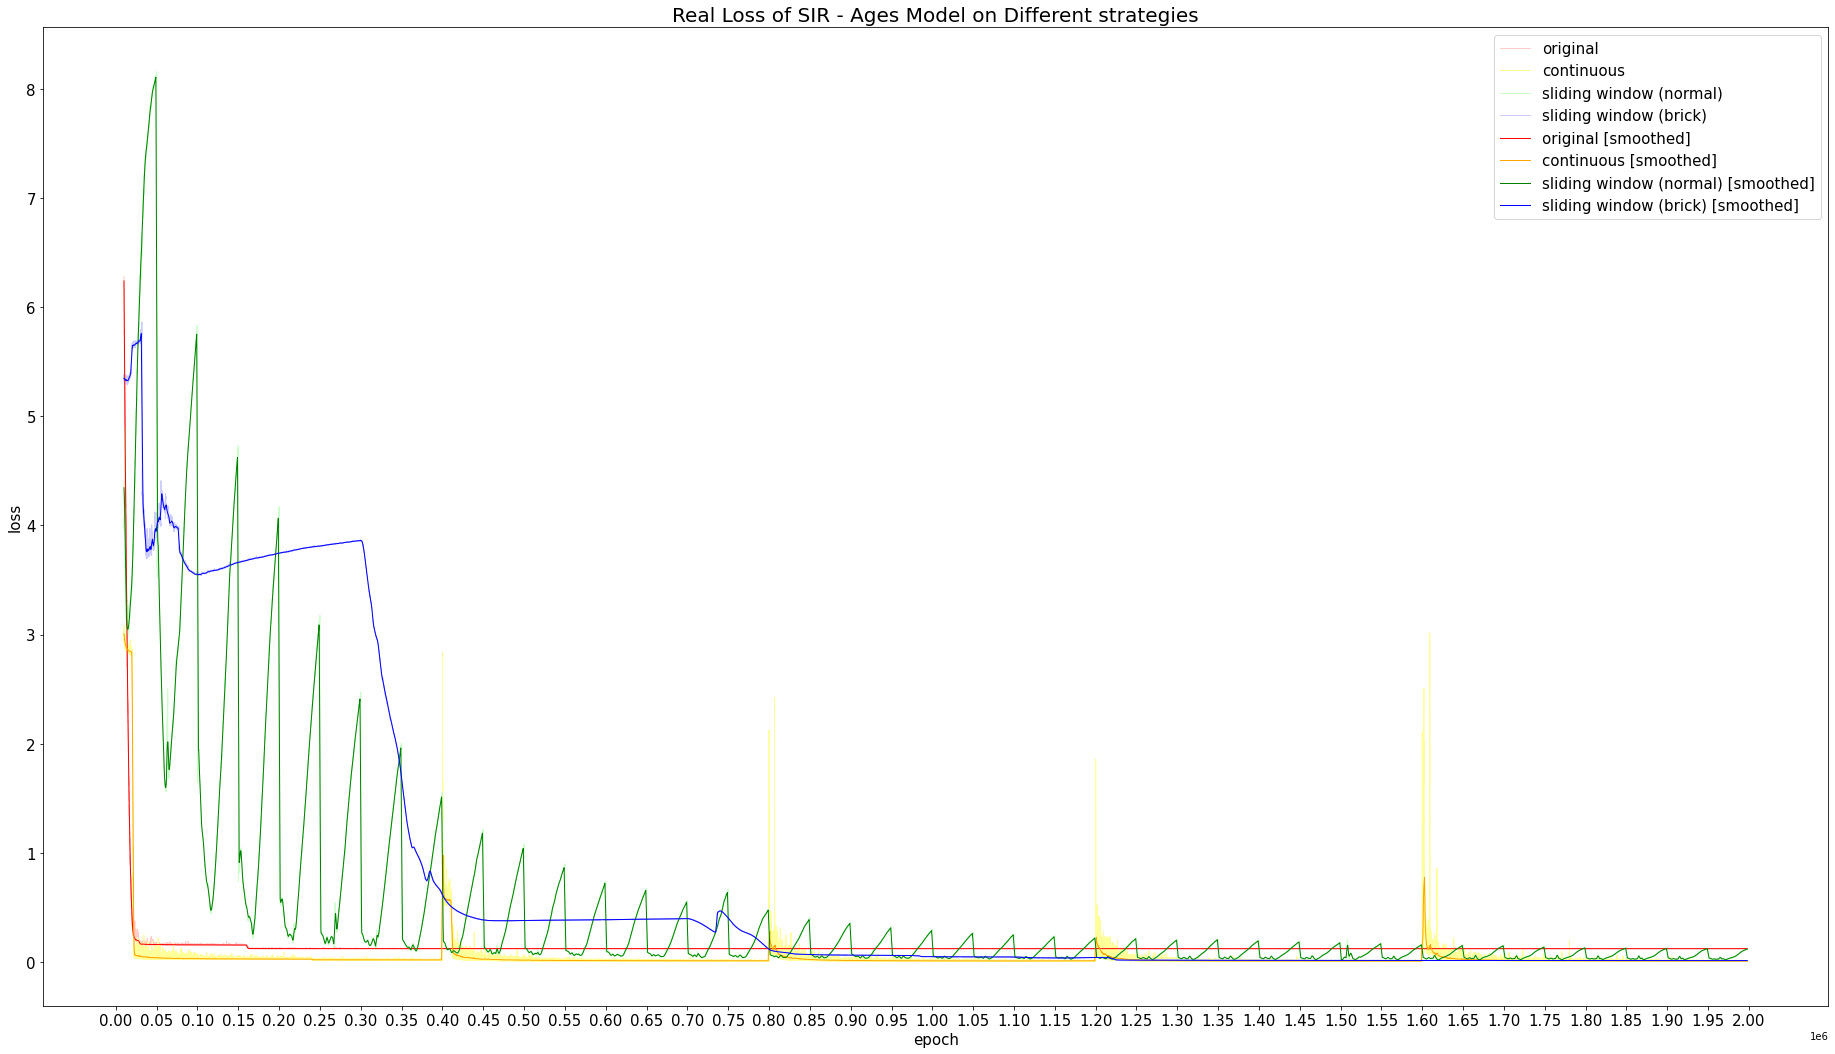

In [9]:
# /content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-05-22-01-53_real_loss_2000000.npy
# 0706 - 3
loss_path_list = [
    "/content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-04-21-49-49_real_loss_2000000.npy",  # original
    "/content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_2022-07-05-18-18-06_real_loss_all.npy",  # continuous
    "/content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-06-23-27-54_real_loss_2000000.npy",  # sliding - normal
    "/content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-08-01-13-05_real_loss_2000000.npy",  # sliding - brick
]

start_index = 10000
draw_multiple_loss(
    loss_path_list=loss_path_list,
    color_list=["#ffcccc", "#ffff99", "#ccffcc", "#ccccff", "r", "orange", "g", "b"],
    line_style_list=["solid"] * 8,
    legend_list=["original", "continuous", "sliding window (normal)", "sliding window (brick)", "original [smoothed]", "continuous [smoothed]", "sliding window (normal) [smoothed]", "sliding window (brick) [smoothed]"],
    fig_title="Real Loss of SIR - Ages Model on Different strategies",
    threshold = 0.5,
    start_index=start_index,
    end_index=2000000-2000,
    smooth_kernel_size=2000,
    fig_size=(32,18),
    line_width=1,
    x_ticks_set_flag=True,
    x_ticks=range(0, 2050000, 50000)
)

length: [2000000, 2000000, 2000000, 2000000]
original: 0.12281430666432623
Epoch 19373 is the first value matches condition '< 0.5'!
continuous: 0.017928035322912927
Epoch 21707 is the first value matches condition '< 0.5'!
sliding window (normal): 0.0739266378866807
Epoch 115699 is the first value matches condition '< 0.5'!
sliding window (brick): 0.02116184881687424
Epoch 411976 is the first value matches condition '< 0.5'!


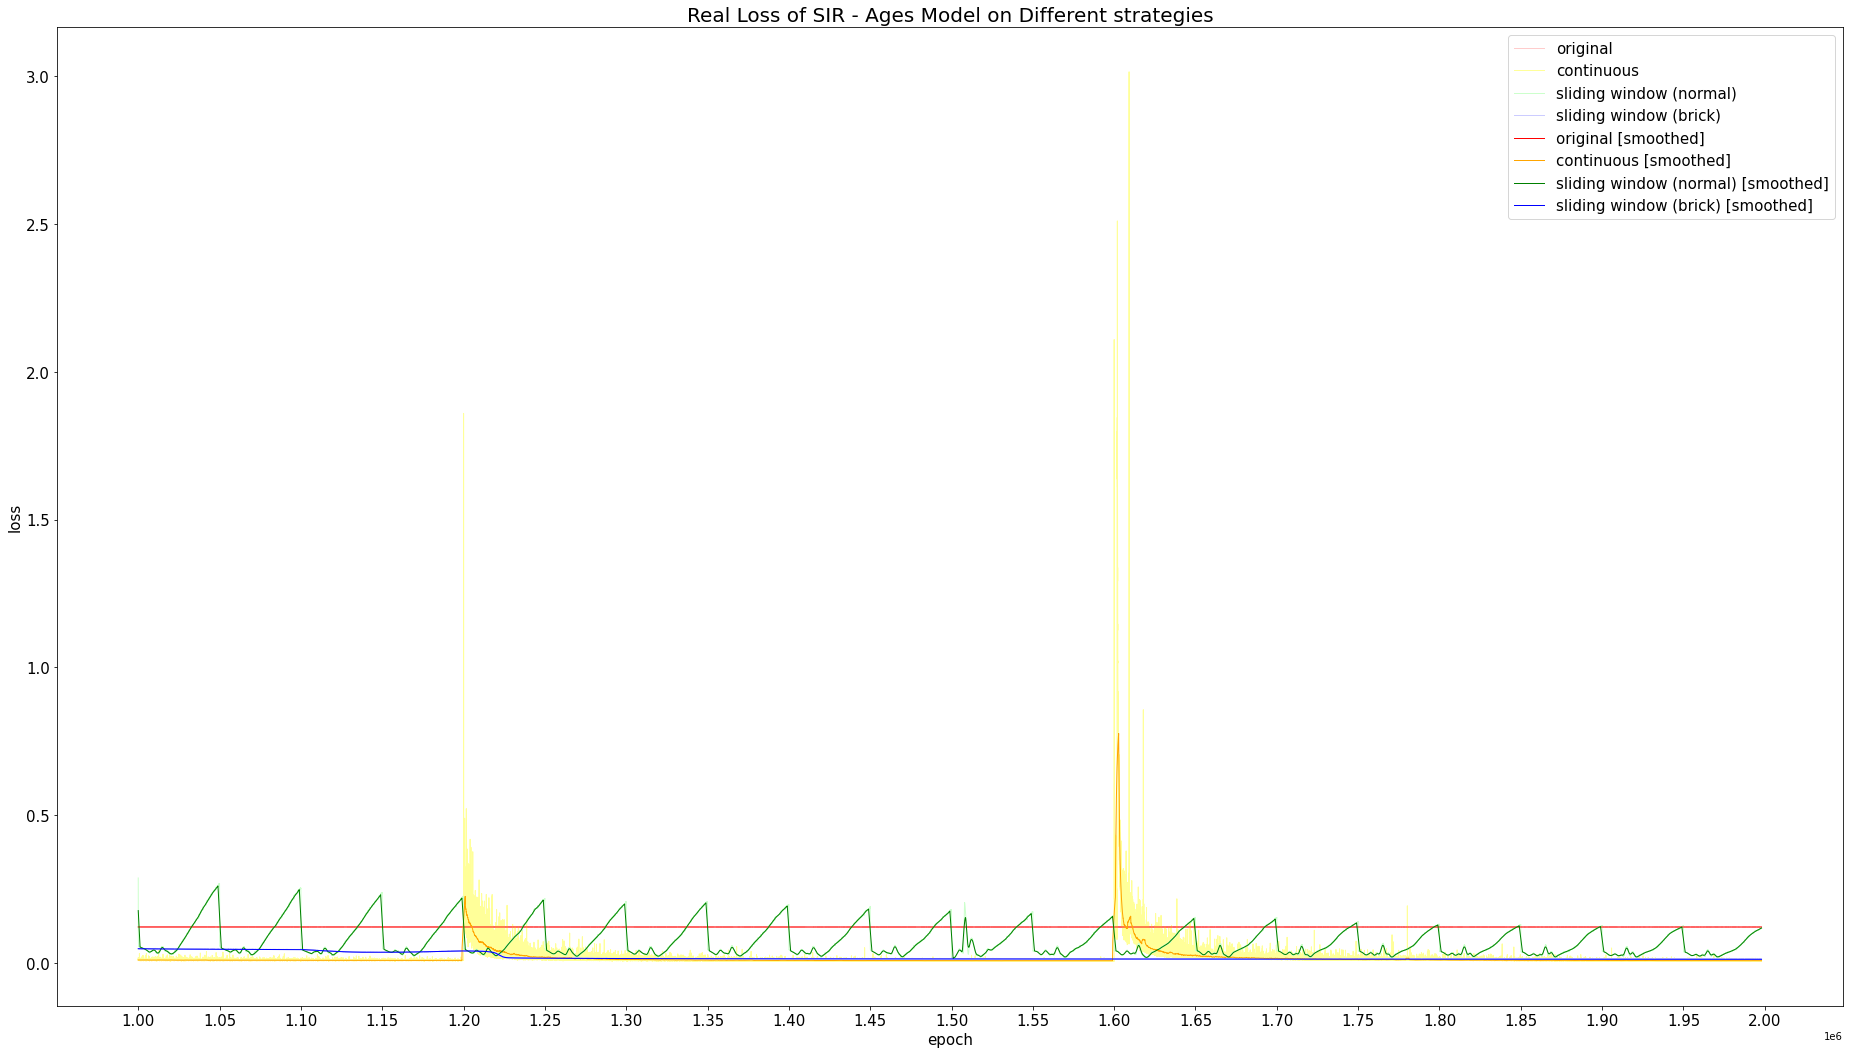

In [8]:
# /content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-05-22-01-53_real_loss_2000000.npy
# 0706 - 3
loss_path_list = [
    "/content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-04-21-49-49_real_loss_2000000.npy",  # original
    "/content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_2022-07-05-18-18-06_real_loss_all.npy",  # continuous
    "/content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-06-23-27-54_real_loss_2000000.npy",  # sliding - normal
    "/content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-08-01-13-05_real_loss_2000000.npy",  # sliding - brick
]

start_index = 1000000
draw_multiple_loss(
    loss_path_list=loss_path_list,
    color_list=["#ffcccc", "#ffff99", "#ccffcc", "#ccccff", "r", "orange", "g", "b"],
    line_style_list=["solid"] * 8,
    legend_list=["original", "continuous", "sliding window (normal)", "sliding window (brick)", "original [smoothed]", "continuous [smoothed]", "sliding window (normal) [smoothed]", "sliding window (brick) [smoothed]"],
    fig_title="Real Loss of SIR - Ages Model on Different strategies",
    threshold = 0.5,
    start_index=start_index,
    end_index=2000000-2000,
    smooth_kernel_size=2000,
    fig_size=(32,18),
    line_width=1,
    x_ticks_set_flag=True,
    x_ticks=range(start_index, 2050000, 50000)
)

original: 0.1378605911949605
Epoch 19373 is the first value matches condition '< 0.5'!
continuous: 0.03977788616203033
Epoch 21707 is the first value matches condition '< 0.5'!


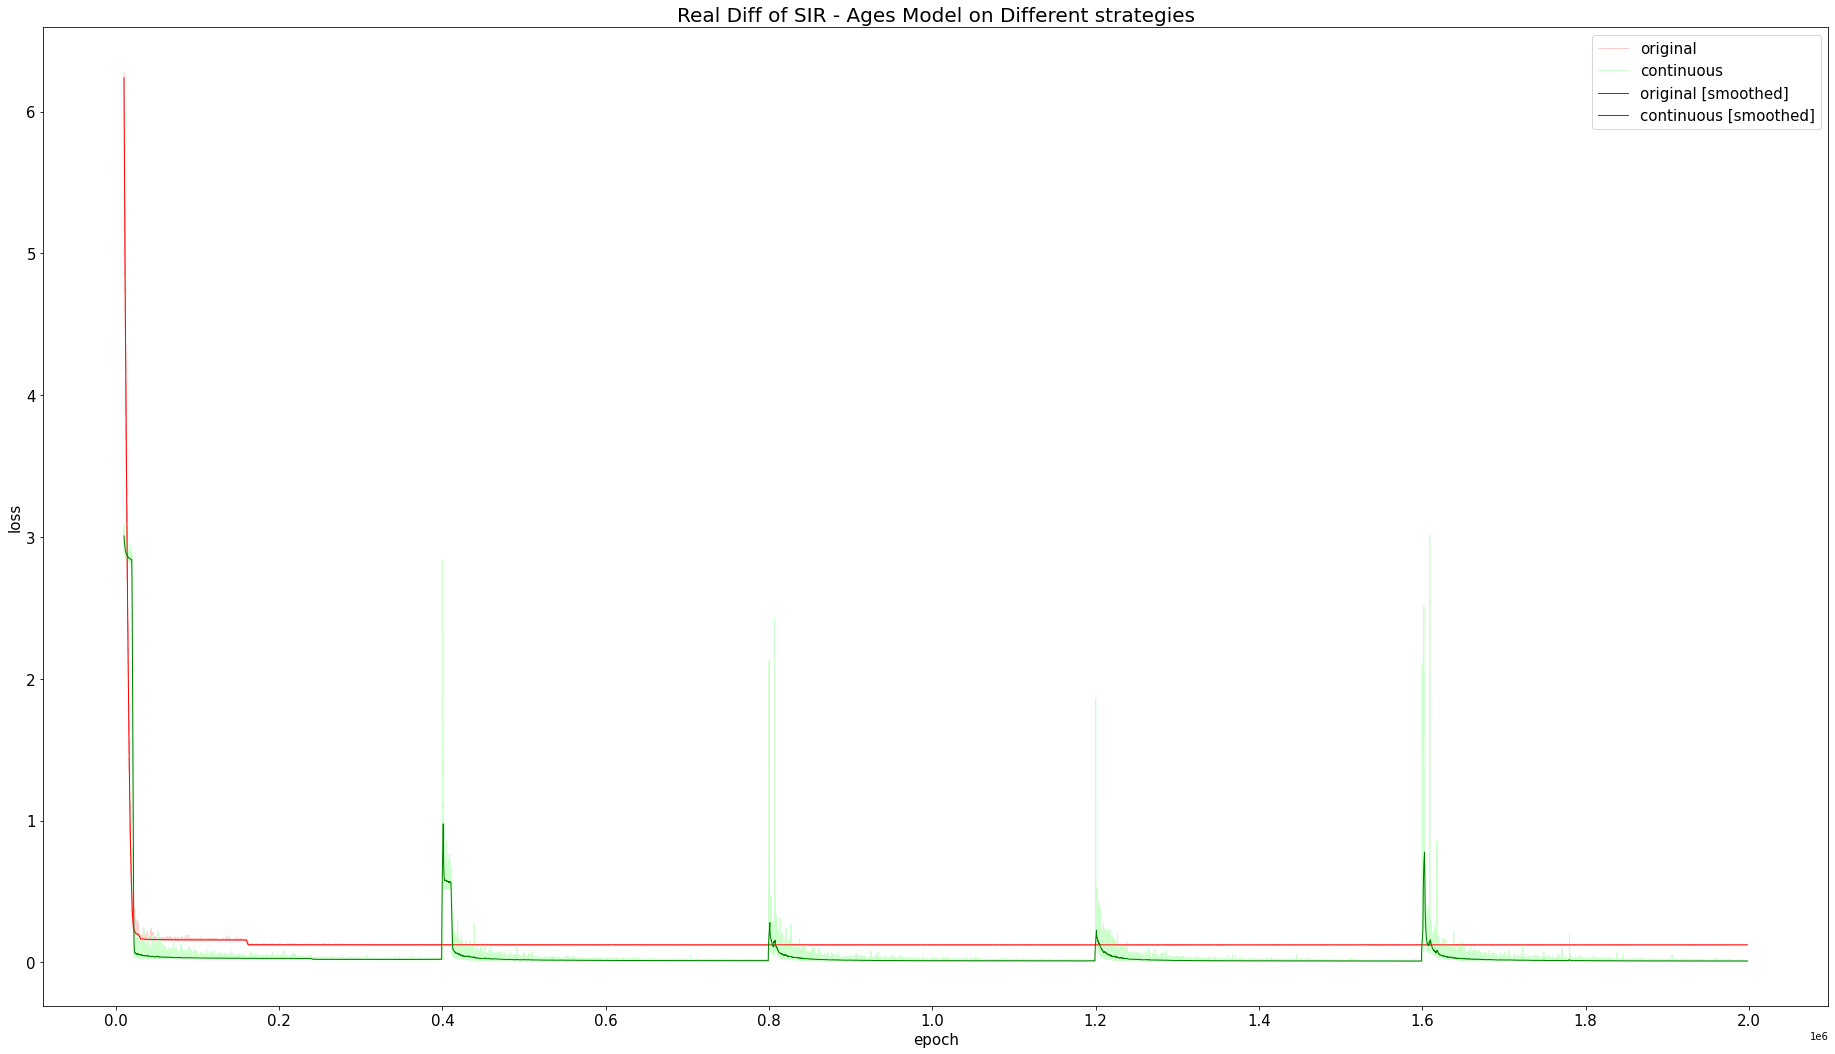

In [ ]:
# 0706 - 2
loss_path_list = [
    "/content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_2000000_5000_0.01_2022-07-04-21-49-49_real_loss_2000000.npy",  # original
    "/content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_2022-07-05-18-18-06_real_loss_all.npy",  # continuous
    # "/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_500000_5000_0.01_2022-06-29-23-41-11_real_loss_500000.npy"
]
draw_multiple_loss(
    loss_path_list=loss_path_list,
    color_list=["#ffcccc", "#ccffcc", "r", "g"],
    line_style_list=["solid"] * 4,
    legend_list=["original", "continuous", "original [smoothed]", "continuous [smoothed]"],
    fig_title="Real Diff of SIR - Ages Model on Different strategies",
    threshold = 0.5,
    start_index=10000,
    end_index=2000000-2000,
    smooth_kernel_size=2000,
    fig_size=(32,18),
    line_width=1,
    x_ticks_set_flag=True,
    x_ticks=range(0, 2100000, 200000)
)
# draw_multiple_loss(
#     loss_path_list=loss_path_list,
#     color_list=["#ffcccc", "#ccffcc", "#ccccff", "r", "g", "b"],
#     line_style_list=["solid"] * 6,
#     legend_list=["original", "continuous", "sliding window (normal)", "original [smoothed]", "continuous [smoothed]", "sliding window (normal) [smoothed]"],
#     fig_title="Real Diff of SIR - Ages Model on Different strategies",
#     threshold = 0.5,
#     start_index=0,
#     end_index=500000,
#     smooth_kernel_size=2000,
#     fig_size=(32,18),
#     line_width=1
# )

[continuous] self.x_real: shape = torch.Size([1000, 15])
truth_x length: 800
truth_y length: 800
real_loss_record_list shape: 4
[continuous] self.x_real: shape = torch.Size([1000, 15])
i = 4, length of truth = 800 now
truth_x: [0.0, 0.1] ... [79.8, 79.9]
truth_y: [array([49.99991 , 50.00231 , 49.999615, 50.000103, 49.99997 , 39.999615,
       39.976845, 40.00042 , 39.999367, 39.99981 , 10.000048, 10.000284,
       10.000008, 10.000023,  9.999997], dtype=float32), array([49.467583, 48.931908, 49.465626, 49.583447, 49.907276, 40.36223 ,
       40.877167, 40.364388, 40.24618 , 39.922646, 10.170336, 10.170599,
       10.170281, 10.170117, 10.16989 ], dtype=float32)] ... [array([23.668047, 13.794698, 23.656712, 27.220335, 49.892338, 28.468922,
       32.313637, 28.474663, 27.076214, 18.105059, 47.85859 , 53.88664 ,
       47.86799 , 45.70188 , 32.002308], dtype=float32), array([23.667746 , 13.7943735, 23.656548 , 27.220425 , 49.896297 ,
       28.470352 , 32.313946 , 28.476093 , 27.077856 ,

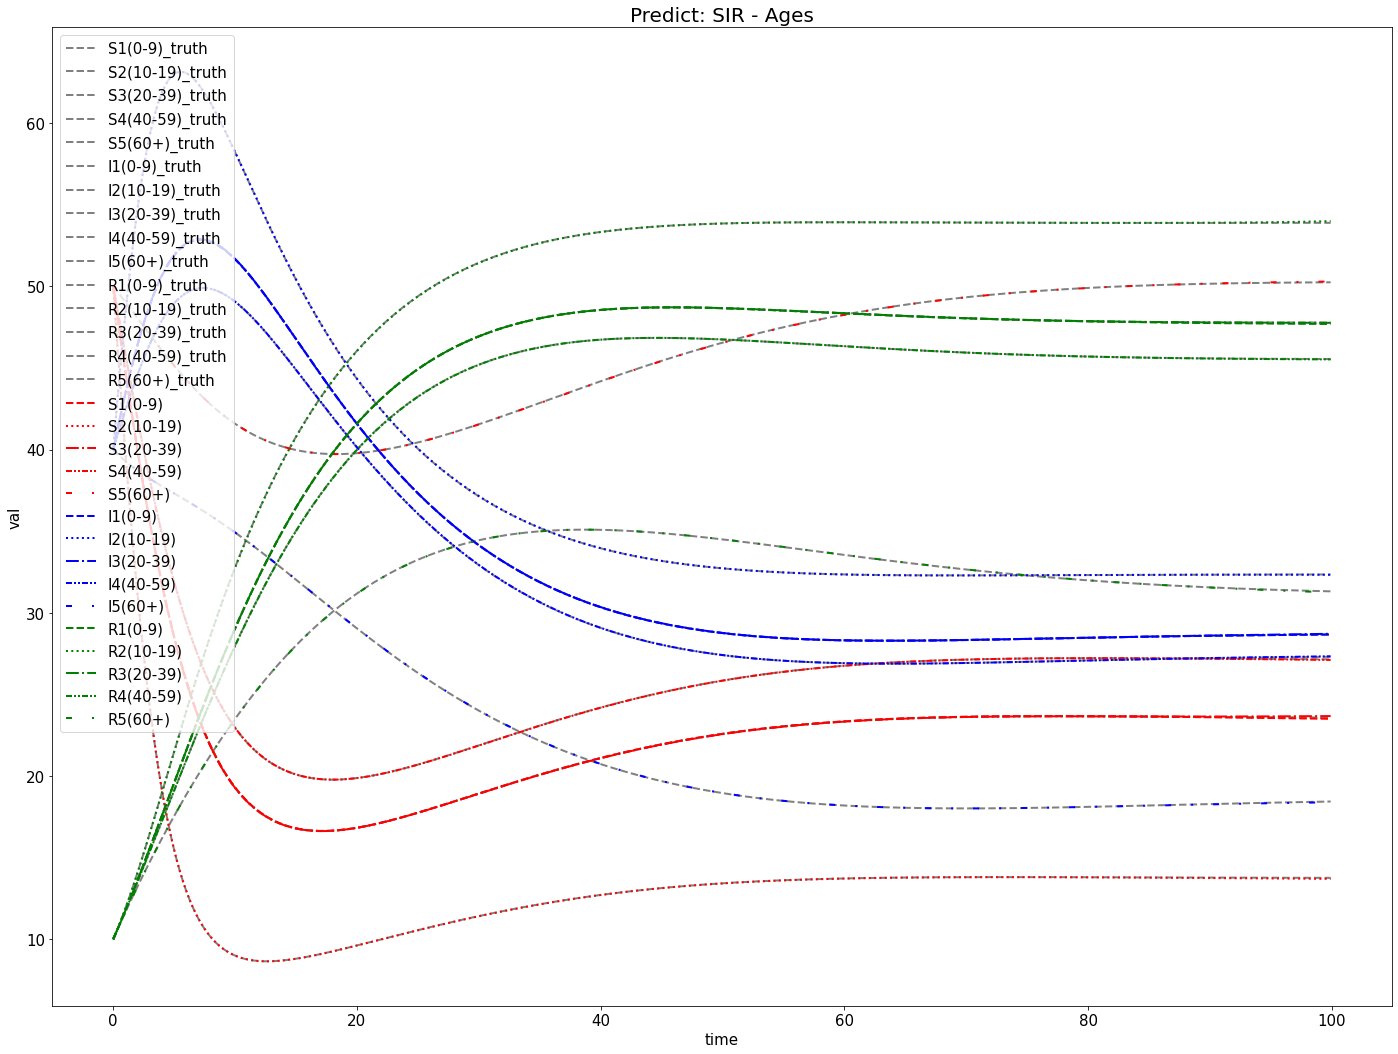

using cuda
epoch = 400000
epoch_step = 5000
model_name = SimpleNetworkSIRAges_Truth
now_string = 2022-07-05-18-18-06
model_save_path_last = /content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_400000_5000_0.01_0.01_0.05_2022-07-05-18-18-06_last.pt
model_save_path_best = /content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_400000_5000_0.01_0.01_0.05_2022-07-05-18-18-06_best.pt
loss_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-05-18-18-06_loss_400000.npy
real_loss_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-05-18-18-06_real_loss_400000.npy
y_record_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-05-18-18-06_y_record.npy


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:870: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


Epoch [05000/400000] Loss:0.348895 Loss_1:0.120932 Loss_2:0.068380 Loss_3:0.000001 Loss_4:0.159582 Lr:0.006667 Time:416.493442s (6.94min in total, 548.38min remains)
Epoch [10000/400000] Loss:0.277968 Loss_1:0.069348 Loss_2:0.039629 Loss_3:0.000001 Loss_4:0.168989 Lr:0.005000 Time:417.951015s (13.91min in total, 542.39min remains)
Epoch [15000/400000] Loss:0.213771 Loss_1:0.091212 Loss_2:0.024531 Loss_3:0.000001 Loss_4:0.098026 Lr:0.004000 Time:425.086900s (20.99min in total, 538.80min remains)
Epoch [20000/400000] Loss:0.157563 Loss_1:0.050143 Loss_2:0.018726 Loss_3:0.000001 Loss_4:0.088693 Lr:0.003333 Time:422.402604s (28.03min in total, 532.61min remains)
Epoch [25000/400000] Loss:0.141736 Loss_1:0.084926 Loss_2:0.016899 Loss_3:0.000001 Loss_4:0.039910 Lr:0.002857 Time:419.344152s (35.02min in total, 525.32min remains)
Epoch [30000/400000] Loss:0.105924 Loss_1:0.063888 Loss_2:0.013233 Loss_3:0.000001 Loss_4:0.028802 Lr:0.002500 Time:423.278512s (42.08min in total, 518.94min remains)

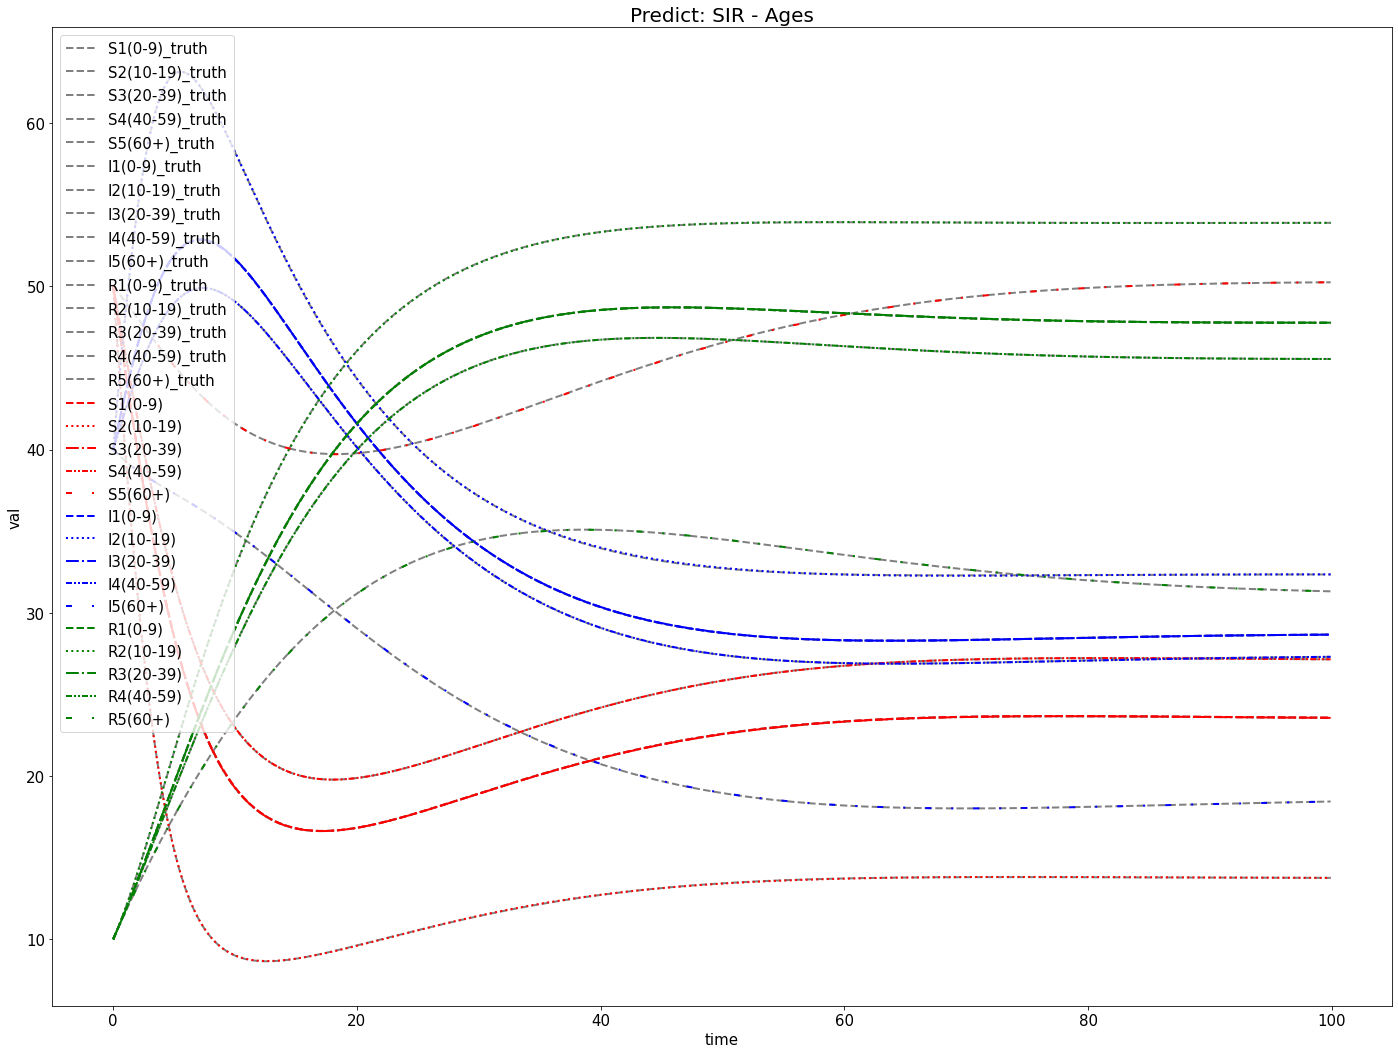

[Loss]


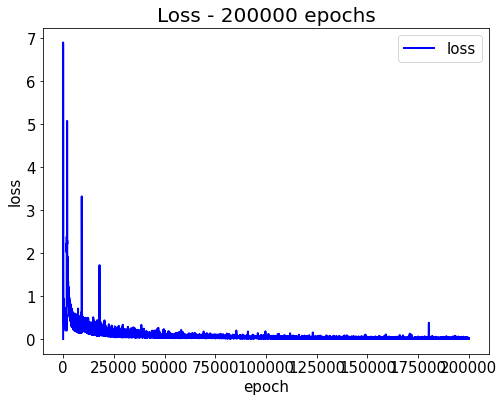

[Real Loss]


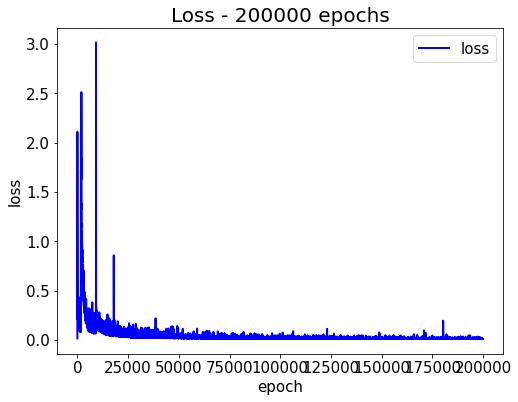

Epoch [205000/400000] Loss:0.030602 Loss_1:0.015456 Loss_2:0.002619 Loss_3:0.000001 Loss_4:0.012527 Lr:0.000465 Time:492.503143s (288.05min in total, 274.00min remains)
Epoch [210000/400000] Loss:0.016069 Loss_1:0.006588 Loss_2:0.001788 Loss_3:0.000001 Loss_4:0.007692 Lr:0.000455 Time:412.637945s (294.93min in total, 266.84min remains)
Epoch [215000/400000] Loss:0.017926 Loss_1:0.009483 Loss_2:0.001720 Loss_3:0.000001 Loss_4:0.006722 Lr:0.000444 Time:408.187620s (301.73min in total, 259.63min remains)
Epoch [220000/400000] Loss:0.016447 Loss_1:0.008177 Loss_2:0.001836 Loss_3:0.000001 Loss_4:0.006432 Lr:0.000435 Time:406.713641s (308.51min in total, 252.42min remains)
Epoch [225000/400000] Loss:0.017449 Loss_1:0.008818 Loss_2:0.001601 Loss_3:0.000001 Loss_4:0.007029 Lr:0.000426 Time:407.195469s (315.30min in total, 245.23min remains)
Epoch [230000/400000] Loss:0.024354 Loss_1:0.014640 Loss_2:0.001868 Loss_3:0.000001 Loss_4:0.007844 Lr:0.000417 Time:406.901084s (322.08min in total, 238.0

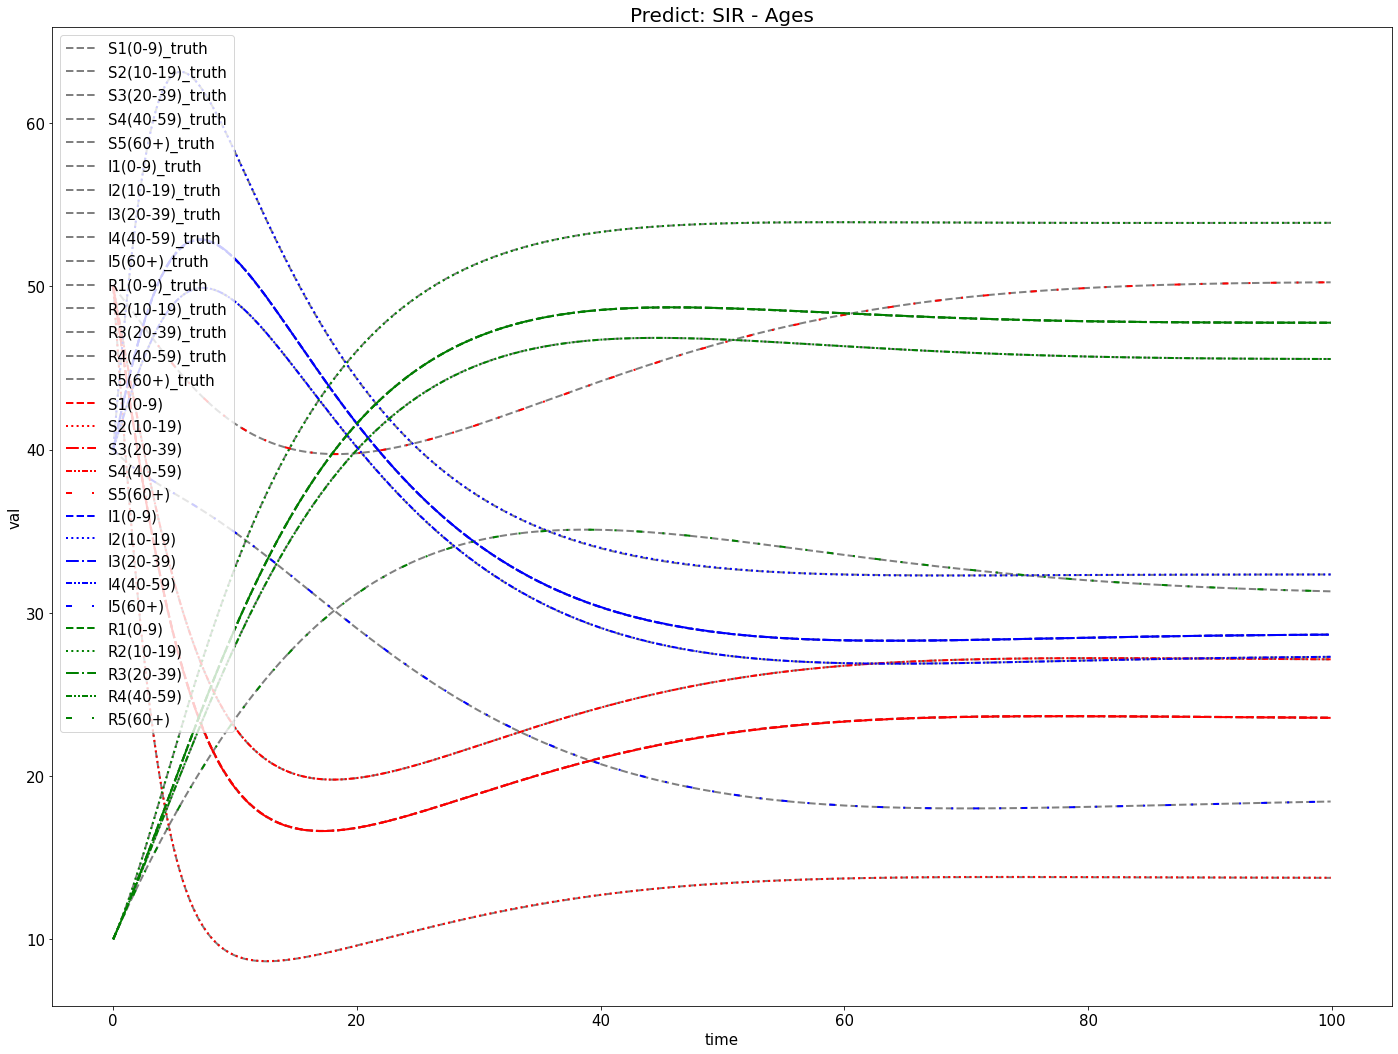

[Loss]


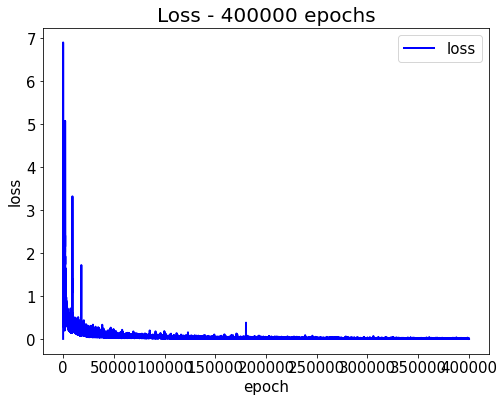

[Real Loss]


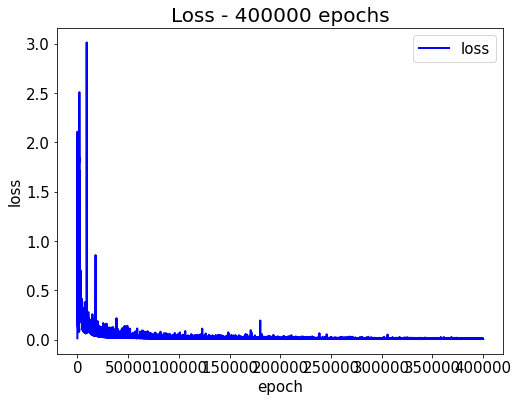

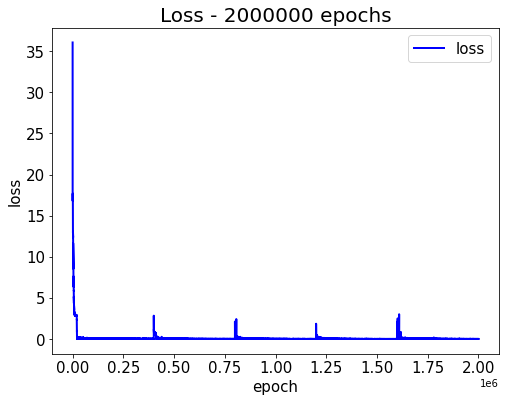

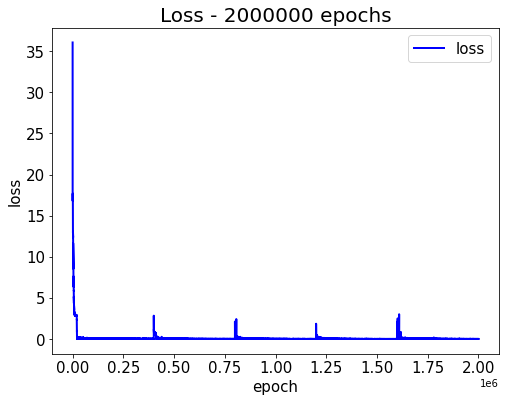

real_loss_all is saved to /content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_2022-07-05-18-18-06_real_loss_all.npy (length=2000000)


In [ ]:
# resume - pickle2
args_0 = Args()
if main_path:
    args_0.main_path = main_path
if not os.path.exists("{}/train".format(args_0.main_path)):
    os.makedirs("{}/train".format(args_0.main_path))
if not os.path.exists("{}/figure".format(args_0.main_path)):
    os.makedirs("{}/figure".format(args_0.main_path))
if not os.path.exists("{}/loss".format(args_0.main_path)):
    os.makedirs("{}/loss".format(args_0.main_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
now_string_list = []
config_0 = ConfigSIRAges()
continue_n = int(1.0 / config_0.continue_period)
# SimpleNetworkSIRAges_Truth_2022-07-04-17-58-40_i=2
with open("/content/drive/My Drive/enze/workspace/PINN/train/SimpleNetworkSIRAges_Truth_2022-07-05-05-47-52_i=3.model", "rb") as f:
    model = pickle.load(f)
truth_x = []
truth_y = []
y = model(model.x)
y = y.cpu().detach().numpy()
for one_x, one_y in zip(model.accurate_x, y):
    one_x = round(one_x, model.config.round_bit)
    if not one_x in truth_x:
        truth_x.append(one_x)
        truth_y.append(one_y)
print("truth_x length:", len(truth_x))
print("truth_y length:", len(truth_y))

real_loss_record_list = []
now_string_list = ['2022-07-04-05-32-17', '2022-07-04-11-28-43', '2022-07-04-17-58-40', '2022-07-05-05-47-52']
real_loss_record_list.append(list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-04-05-32-17_real_loss_400000.npy")))
real_loss_record_list.append(list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-04-11-28-43_real_loss_400000.npy")))
real_loss_record_list.append(list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-04-17-58-40_real_loss_400000.npy")))
real_loss_record_list.append(list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-05-05-47-52_real_loss_400000.npy")))


print("real_loss_record_list shape:", len(real_loss_record_list))

for i in range(4, 5):
        
    config = ConfigSIRAges()
    config.T = config_0.T * config_0.continue_period * (i + 1)
    config.N = int(config.T / config.T_unit)
    config.ub = config.T
    config.continue_id = i
    args = copy.deepcopy(args_0)
    args.epoch = int(args.epoch * config_0.continue_period)
    
    now_string = get_now_string()
    
    print("i = {}, length of truth = {} now".format(i, len(truth_x)))
    print("truth_x:", truth_x[:2], "...", truth_x[-2:])
    print("truth_y:", truth_y[:2], "...", truth_y[-2:])
    
    model = SimpleNetworkSIRAges(config, [truth_x, truth_y]).to(device)
    if i > 0:
        model_state_dict_path =  f"{args.main_path}/train/{config.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string_list[-1]}_best.pt"
        model.load_state_dict(torch.load(model_state_dict_path, map_location=device)["model_state_dict"])
        print("Loaded previous trained model from {} successfully!".format(model_state_dict_path))
        print("Test before training...")
        print("Now string list:", now_string_list)
        test_sir_ages(model, args, config, now_string_list[-1], True, model.gt)
    now_string_list.append(now_string)
    model, res_dic = train_sir_ages(model, args, config, now_string)
    with open(f"{args.main_path}/train/{config.model_name}_{now_string}_i={i}.model", "wb") as f:
        pickle.dump(model, f)
    real_loss_record_list.append(res_dic["real_loss_record"])
    draw_loss(np.concatenate(real_loss_record_list))
    np.save(f"{args.main_path}/train/{config.model_name}_{now_string}_real_loss_record_i={i}.pt", np.concatenate(real_loss_record_list))
    y = model(model.x)
    y = y.cpu().detach().numpy()
    # print("model.accurate_x:", model.accurate_x)
    # print("y:", y)
    for one_x, one_y in zip(model.accurate_x, y):
        one_x = round(one_x, model.config.round_bit)
        if not one_x in truth_x:
            truth_x.append(one_x)
            truth_y.append(one_y)
real_loss_record_all = np.concatenate(real_loss_record_list)
draw_loss(real_loss_record_all)
real_loss_all_path = f"{args_0.main_path}/train/{config_0.model_name}_{now_string}_real_loss_all.npy"
np.save(real_loss_all_path, real_loss_record_all)
print("real_loss_all is saved to {} (length={})".format(real_loss_all_path, len(real_loss_record_all)))

[continuous] self.x_real: shape = torch.Size([1000, 15])
truth_x length: 600
truth_y length: 600
real_loss_record_list shape: 1200000
[continuous] self.x_real: shape = torch.Size([1000, 15])
i = 3, length of truth = 600 now
truth_x: [0.0, 0.1] ... [59.8, 59.9]
truth_y: [array([49.999947, 50.01323 , 49.99986 , 49.999958, 49.999973, 39.999626,
       40.010998, 39.999588, 39.99961 , 39.999187, 10.000035, 10.003032,
        9.999995, 10.000016,  9.999962], dtype=float32), array([49.467457, 48.94326 , 49.46581 , 49.58338 , 49.9072  , 40.36234 ,
       40.910767, 40.363255, 40.246517, 39.92202 , 10.170412, 10.173555,
       10.170054, 10.170059, 10.169874], dtype=float32)] ... [array([23.340355, 13.722219, 23.324354, 26.744709, 48.226704, 28.310892,
       32.352253, 28.318   , 26.916437, 18.204079, 48.348858, 53.925785,
       48.357693, 46.338512, 33.5661  ], dtype=float32), array([23.345121, 13.723841, 23.329195, 26.750809, 48.240566, 28.309378,
       32.35069 , 28.316559, 26.914734, 18

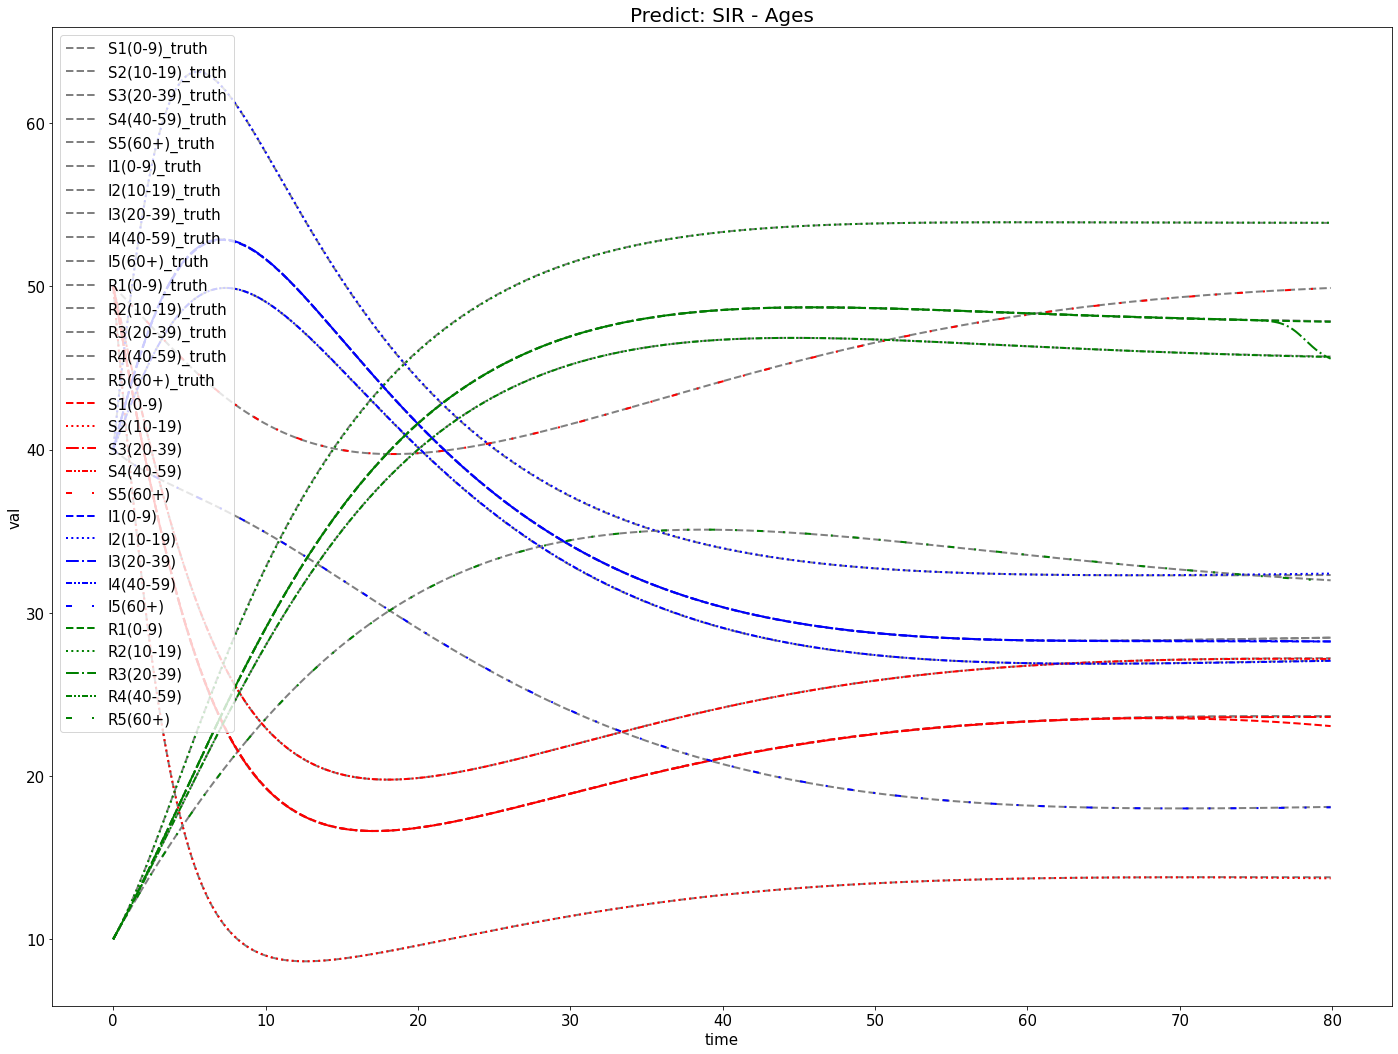

using cuda
epoch = 400000
epoch_step = 5000
model_name = SimpleNetworkSIRAges_Truth
now_string = 2022-07-05-05-47-52
model_save_path_last = /content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_400000_5000_0.01_0.01_0.05_2022-07-05-05-47-52_last.pt
model_save_path_best = /content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_400000_5000_0.01_0.01_0.05_2022-07-05-05-47-52_best.pt
loss_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-05-05-47-52_loss_400000.npy
real_loss_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-05-05-47-52_real_loss_400000.npy
y_record_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-05-05-47-52_y_record.npy
Epoch [05000/400000] Loss:0.240273 Loss_1:0.064848 Loss_2:0.046857 Loss_3:0.000001 Loss_4:0.128567 Lr:0.006667 Time:297

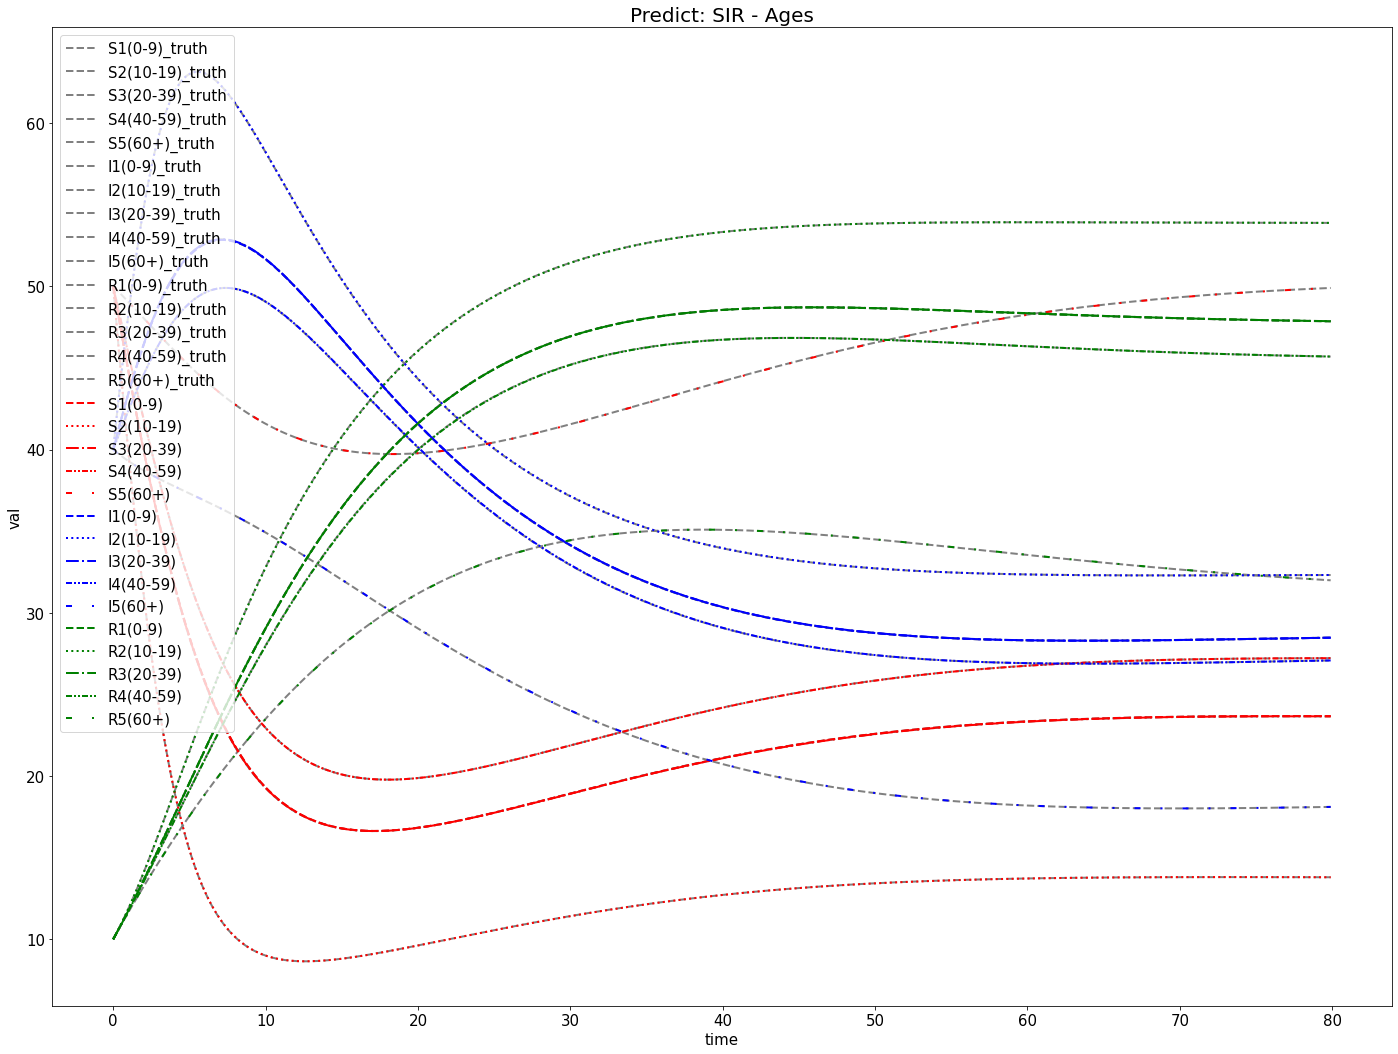

[Loss]


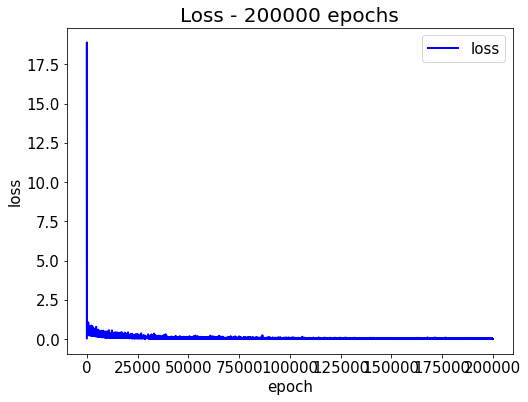

[Real Loss]


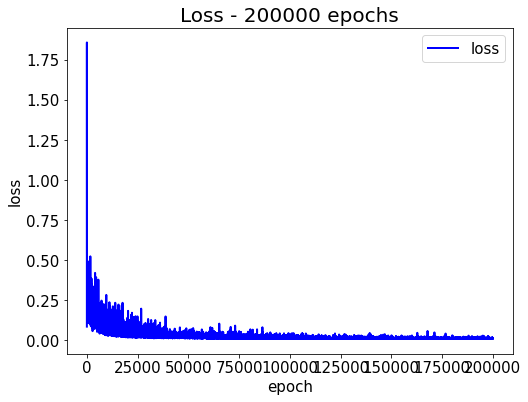

Epoch [205000/400000] Loss:0.011717 Loss_1:0.006837 Loss_2:0.000976 Loss_3:0.000001 Loss_4:0.003902 Lr:0.000465 Time:351.797868s (203.78min in total, 193.84min remains)
Epoch [210000/400000] Loss:0.014039 Loss_1:0.007281 Loss_2:0.001112 Loss_3:0.000001 Loss_4:0.005646 Lr:0.000455 Time:291.779941s (208.64min in total, 188.77min remains)
Epoch [215000/400000] Loss:0.012919 Loss_1:0.008919 Loss_2:0.000911 Loss_3:0.000001 Loss_4:0.003088 Lr:0.000444 Time:292.929815s (213.52min in total, 183.73min remains)
Epoch [220000/400000] Loss:0.013129 Loss_1:0.007326 Loss_2:0.001337 Loss_3:0.000001 Loss_4:0.004464 Lr:0.000435 Time:294.684242s (218.43min in total, 178.72min remains)
Epoch [225000/400000] Loss:0.012445 Loss_1:0.008840 Loss_2:0.001323 Loss_3:0.000001 Loss_4:0.002281 Lr:0.000426 Time:293.162589s (223.32min in total, 173.69min remains)
Epoch [230000/400000] Loss:0.013053 Loss_1:0.008852 Loss_2:0.000914 Loss_3:0.000001 Loss_4:0.003285 Lr:0.000417 Time:295.425896s (228.24min in total, 168.7

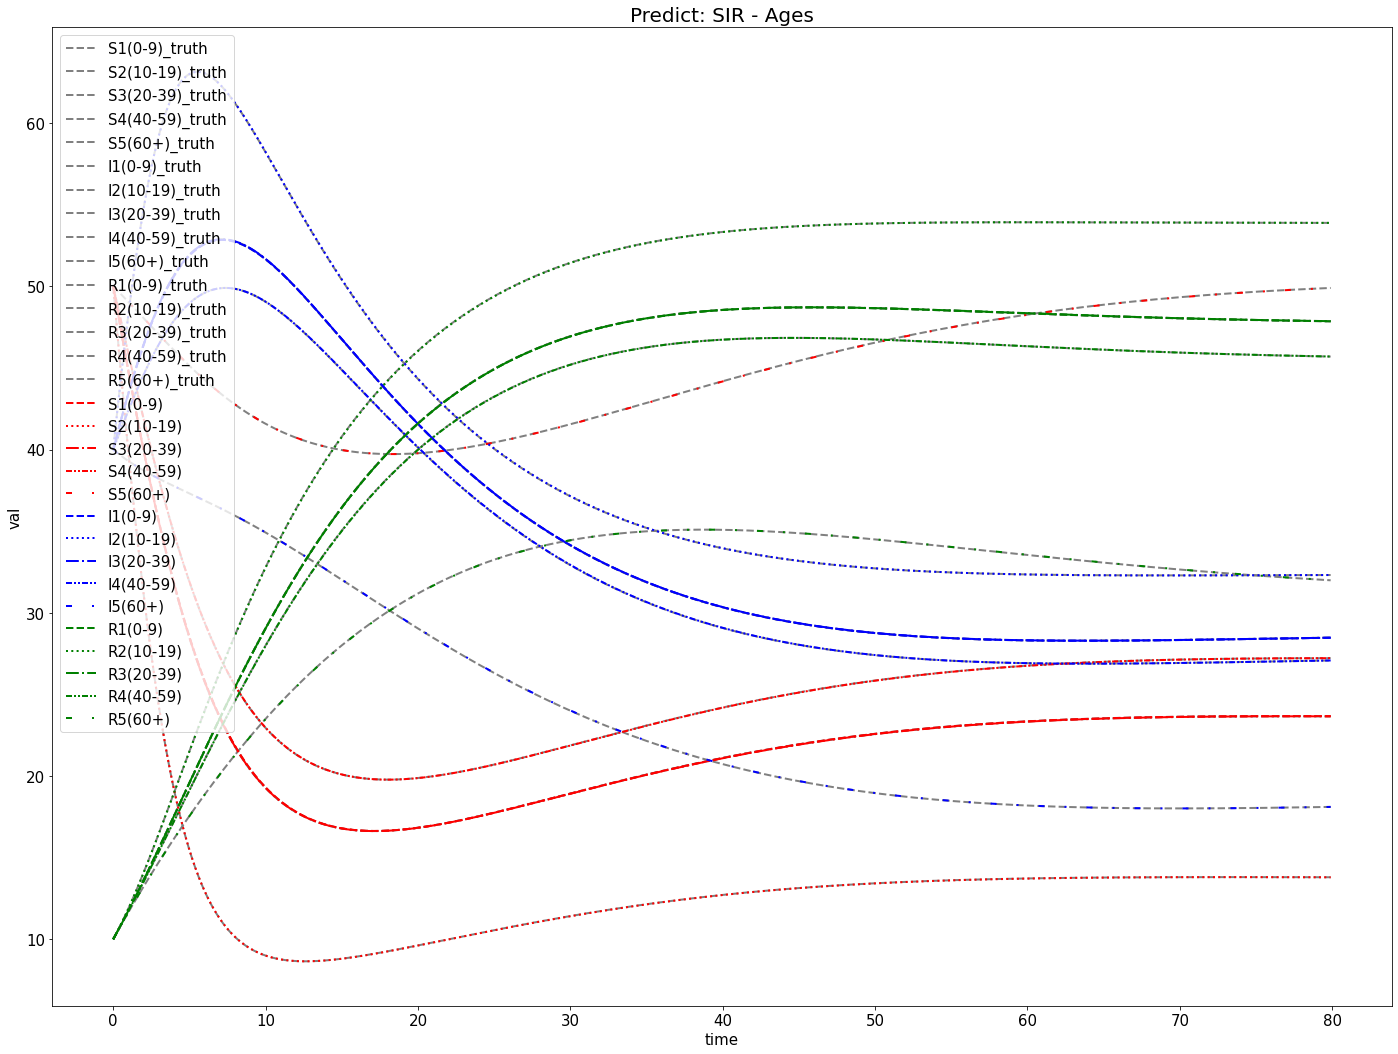

[Loss]


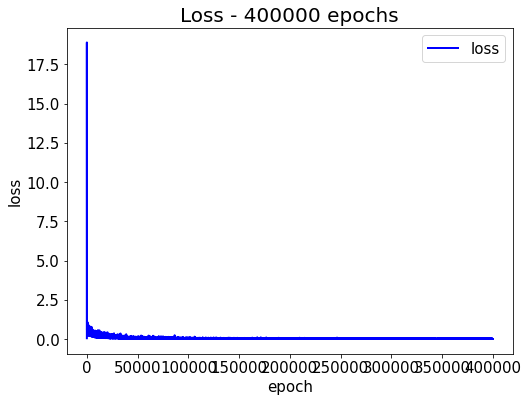

[Real Loss]


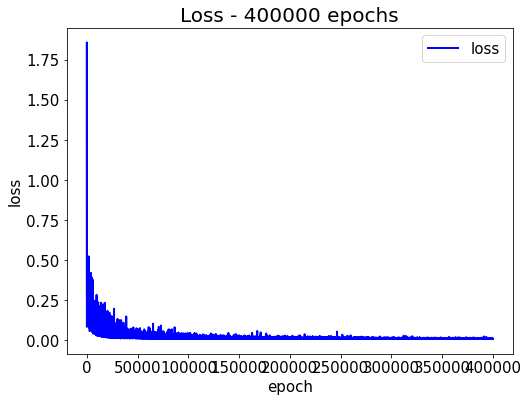

ValueError: ignored

In [ ]:
# resume - pickle
args_0 = Args()
if main_path:
    args_0.main_path = main_path
if not os.path.exists("{}/train".format(args_0.main_path)):
    os.makedirs("{}/train".format(args_0.main_path))
if not os.path.exists("{}/figure".format(args_0.main_path)):
    os.makedirs("{}/figure".format(args_0.main_path))
if not os.path.exists("{}/loss".format(args_0.main_path)):
    os.makedirs("{}/loss".format(args_0.main_path))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
now_string_list = []
config_0 = ConfigSIRAges()
continue_n = int(1.0 / config_0.continue_period)
# SimpleNetworkSIRAges_Truth_2022-07-04-17-58-40_i=2
with open("/content/drive/My Drive/enze/workspace/PINN/train/SimpleNetworkSIRAges_Truth_2022-07-04-17-58-40_i=2.model", "rb") as f:
    model = pickle.load(f)
truth_x = []
truth_y = []
y = model(model.x)
y = y.cpu().detach().numpy()
for one_x, one_y in zip(model.accurate_x, y):
    one_x = round(one_x, model.config.round_bit)
    if not one_x in truth_x:
        truth_x.append(one_x)
        truth_y.append(one_y)
print("truth_x length:", len(truth_x))
print("truth_y length:", len(truth_y))

# real_loss_record_list = []
now_string_list = ['2022-07-04-05-32-17', '2022-07-04-11-28-43', '2022-07-04-17-58-40']
real_loss_record_list = \
  list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-04-05-32-17_real_loss_400000.npy")) + \
  list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-04-11-28-43_real_loss_400000.npy")) + \
  list(np.load("/content/drive/My Drive/enze/workspace/PINN/loss/SimpleNetworkSIRAges_Truth_400000_5000_0.01_2022-07-04-17-58-40_real_loss_400000.npy"))

print("real_loss_record_list shape:", len(real_loss_record_list))

for i in range(3, 5):
        
    config = ConfigSIRAges()
    config.T = config_0.T * config_0.continue_period * (i + 1)
    config.N = int(config.T / config.T_unit)
    config.ub = config.T
    config.continue_id = i
    args = copy.deepcopy(args_0)
    args.epoch = int(args.epoch * config_0.continue_period)
    
    now_string = get_now_string()
    
    print("i = {}, length of truth = {} now".format(i, len(truth_x)))
    print("truth_x:", truth_x[:2], "...", truth_x[-2:])
    print("truth_y:", truth_y[:2], "...", truth_y[-2:])
    
    model = SimpleNetworkSIRAges(config, [truth_x, truth_y]).to(device)
    if i > 0:
        model_state_dict_path =  f"{args.main_path}/train/{config.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string_list[-1]}_best.pt"
        model.load_state_dict(torch.load(model_state_dict_path, map_location=device)["model_state_dict"])
        print("Loaded previous trained model from {} successfully!".format(model_state_dict_path))
        print("Test before training...")
        print("Now string list:", now_string_list)
        test_sir_ages(model, args, config, now_string_list[-1], True, model.gt)
    now_string_list.append(now_string)
    model, res_dic = train_sir_ages(model, args, config, now_string)
    with open(f"{args.main_path}/train/{config.model_name}_{now_string}_i={i}.model", "wb") as f:
        pickle.dump(model, f)
    real_loss_record_list.append(res_dic["real_loss_record"])
    draw_loss(np.concatenate(real_loss_record_list))
    np.save(f"{args.main_path}/train/{config.model_name}_{now_string}_real_loss_record_i={i}.pt", np.concatenate(real_loss_record_list))
    y = model(model.x)
    y = y.cpu().detach().numpy()
    # print("model.accurate_x:", model.accurate_x)
    # print("y:", y)
    for one_x, one_y in zip(model.accurate_x, y):
        one_x = round(one_x, model.config.round_bit)
        if not one_x in truth_x:
            truth_x.append(one_x)
            truth_y.append(one_y)
real_loss_record_all = np.concatenate(real_loss_record_list)
draw_loss(real_loss_record_all)
real_loss_all_path = f"{args_0.main_path}/train/{config_0.model_name}_{now_string}_real_loss_all.npy"
np.save(real_loss_all_path, real_loss_record_all)
print("real_loss_all is saved to {} (length={})".format(real_loss_all_path, len(real_loss_record_all)))




In [ ]:
main_path = "/content/drive/My Drive/enze/workspace/PINN"
run_sir_ages_continue(main_path)

Output hidden; open in https://colab.research.google.com to view.

[continuous] self.x_real: shape = torch.Size([1000, 15])
[continuous] self.x_real: shape = torch.Size([1000, 15])
self.truth_length: 1 of 600 all 
[continuous] self.x: shape = torch.Size([600, 15])
truth_x length: 600
truth_y length: 600
[continuous] self.x_real: shape = torch.Size([1000, 15])
i = 3, length of truth = 600 now
truth_x: [0.0, 0.1] ... [59.8, 59.9]
truth_y: [array([50.001755 , 49.999855 , 49.999744 , 50.011665 , 50.000065 ,
       40.001907 , 39.97755  , 39.99981  , 40.005405 , 40.00003  ,
       10.000446 ,  9.9998045,  9.999898 ,  9.997902 ,  9.998106 ],
      dtype=float32), array([49.468628, 48.930378, 49.46564 , 49.59537 , 49.907314, 40.36468 ,
       40.877857, 40.363533, 40.252068, 39.92295 , 10.170769, 10.170135,
       10.170188, 10.167852, 10.168074], dtype=float32)] ... [array([23.338627, 13.714904, 23.32431 , 26.750774, 48.227566, 28.313494,
       32.353756, 28.32113 , 26.914257, 18.20365 , 48.348705, 53.926952,
       48.357697, 46.339787, 33.566505], dtype=

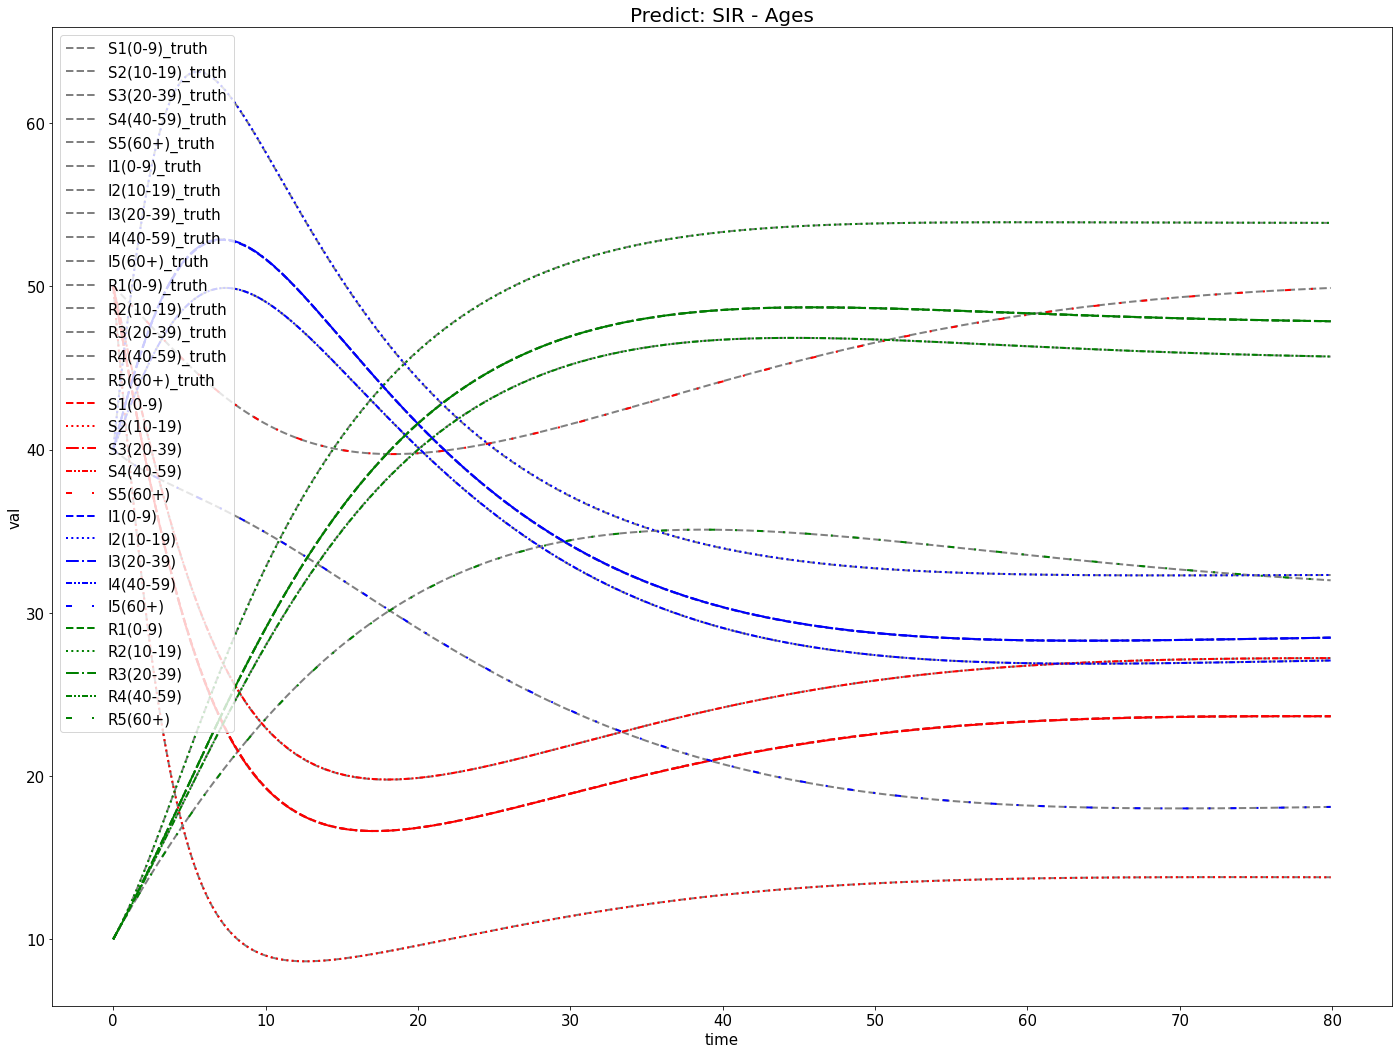

using cuda
epoch = 400000
epoch_step = 10000
model_name = SimpleNetworkSIRAges_Truth
now_string = 2022-07-04-05-07-10
model_save_path_last = /content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_400000_10000_0.01_0.01_0.05_2022-07-04-05-07-10_last.pt
model_save_path_best = /content/drive/My Drive/enze/workspace/PINN//train/SimpleNetworkSIRAges_Truth_400000_10000_0.01_0.01_0.05_2022-07-04-05-07-10_best.pt
loss_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_10000_0.01_2022-07-04-05-07-10_loss_400000.npy
real_loss_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_10000_0.01_2022-07-04-05-07-10_real_loss_400000.npy
y_record_save_path = /content/drive/My Drive/enze/workspace/PINN//loss/SimpleNetworkSIRAges_Truth_400000_10000_0.01_2022-07-04-05-07-10_y_record.npy


KeyboardInterrupt: ignored

In [ ]:
# resume
args_0 = Args()
if main_path:
    args_0.main_path = main_path
if not os.path.exists("{}/train".format(args_0.main_path)):
    os.makedirs("{}/train".format(args_0.main_path))
if not os.path.exists("{}/figure".format(args_0.main_path)):
    os.makedirs("{}/figure".format(args_0.main_path))
if not os.path.exists("{}/loss".format(args_0.main_path)):
    os.makedirs("{}/loss".format(args_0.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config_0 = ConfigSIRAges()
continue_n = int(1.0 / config_0.continue_period)
truth_x = []
truth_y = []

i = 2
config = ConfigSIRAges()
config.T = config_0.T * config_0.continue_period * (i + 1)
config.N = int(config.T / config.T_unit)
config.ub = config.T
config.continue_id = i
args = copy.deepcopy(args_0)
args.epoch = int(args.epoch * config_0.continue_period)
model_state_dict_path = "/content/drive/My Drive/enze/workspace/PINN/train/SimpleNetworkSIRAges_Truth_400000_10000_0.01_0.01_0.05_2022-07-03-03-44-05_last.pt"

model = SimpleNetworkSIRAges(config, [truth_x, truth_y]).to(device)
model.load_state_dict(torch.load(model_state_dict_path, map_location=device)["model_state_dict"])

y = model(model.x)
y = y.cpu().detach().numpy()
for one_x, one_y in zip(model.accurate_x, y):
    one_x = round(one_x, model.config.round_bit)
    if not one_x in truth_x:
        truth_x.append(one_x)
        truth_y.append(one_y)
print("truth_x length:", len(truth_x))
print("truth_y length:", len(truth_y))

now_string = "2022-07-04-05-07-10"

for i in range(3, 5):
        config = ConfigSIRAges()
        config.T = config_0.T * config_0.continue_period * (i + 1)
        config.N = int(config.T / config.T_unit)
        config.ub = config.T
        config.continue_id = i
        args = copy.deepcopy(args_0)
        args.epoch = int(args.epoch * config_0.continue_period)
        model_state_dict_path =  f"{args.main_path}/train/{config.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{config.beta}_{config.gamma}_{now_string}_best.pt"
        
        print("i = {}, length of truth = {} now".format(i, len(truth_x)))
        print("truth_x:", truth_x[:2], "...", truth_x[-2:])
        print("truth_y:", truth_y[:2], "...", truth_y[-2:])
        
        model = SimpleNetworkSIRAges(config, [truth_x, truth_y]).to(device)
        if i > 0:
            model.load_state_dict(torch.load(model_state_dict_path, map_location=device)["model_state_dict"])
            print("Loaded previous trained model from {} successfully!".format(model_state_dict_path))
            print("Test before training...")
            test_sir_ages(model, args, config, now_string, True, model.gt)
        model, res_dic = train_sir_ages(model, args, config, now_string)
        # real_loss_record_list.append(res_dic["real_loss_record"])
        y = model(model.x)
        y = y.cpu().detach().numpy()
        # print("model.accurate_x:", model.accurate_x)
        # print("y:", y)
        for one_x, one_y in zip(model.accurate_x, y):
            one_x = round(one_x, model.config.round_bit)
            if not one_x in truth_x:
                truth_x.append(one_x)
                truth_y.append(one_y)